In [1]:
import os
import glob
import copy
import time
import pickle
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
#from data_loader import*
from data_preprocessing import*

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2,l1
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
def plot_box_plot(model1,model2, group,group1,group2,mode1):
    df = pd.DataFrame({'Subjects':group,model1:group1,model2:group2})
    df = df[['Subjects',model1,model2]]

    fig, ax = plt.subplots(figsize=(20, 10))
    sns.set_style("whitegrid")
    dd=pd.melt(df,id_vars=['Subjects'],value_vars=[model1,model2],var_name='Models')
    ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
    ax.set_title('{} accuracy'.format(mode1))
    ax.set(ylabel='Accuracy')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0,1.01,0.1))
    plt.show()

def plot_roc_curve(results, n_subjects, n_classes, model, dataset):
    for subj in range(1,n_subjects+1):
        fpr = results['fpr'][subj]
        tpr = results['tpr'][subj]
        roc_auc = results['auc'][subj]
        
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], lw=1.5,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i+1, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for subject {}'.format(subj))
        plt.legend(bbox_to_anchor=(1.05, 1.0))
        
        filename = "./visualizations/{}/{}/roc_curve/S{}".format(model,dataset,subj)
        os.makedirs(os.path.dirname(filename), exist_ok=True)   
        plt.savefig(filename)
        
def mean_no_none(l):
    l_no_none = [el for el in l if el is not None]
    return sum(l_no_none) / len(l_no_none)

def aggregate_dicts(dicts, operation=lambda x: sum(x) / len(x)):
    """
    Aggregate a sequence of dictionaries to a single dictionary using `operation`. `Operation` should
    reduce a list of all values with the same key. Keyrs that are not found in one dictionary will
    be mapped to `None`, `operation` can then chose how to deal with those.
    """
    all_keys = set().union(*[el.keys() for el in dicts])
    return {k: operation([dic.get(k, None) for dic in dicts]) for k in all_keys}

def fix_roc(results,n_subjects):
    for i in range(1,n_subjects+1):
        for j in range(1,16):
            fpr_f = results[i][j]['fpr']
            tpr_f = results[i][j]['tpr']
            for k in fpr_f.keys():
                if(len(fpr_f[k])<3):
                    fpr_f[k] = np.array([0,0,1])
                    results[i][j]['fpr'] = fpr_f
                if(len(tpr_f[k])<3):
                    tpr_f[k] = np.array([0,0,1])
                    results[i][j]['tpr'] = tpr_f
    return results

def group_results(results,n_subjects):
    group = []
    category_accuracy = []
    sequence_accuracy = []
    ITR = []
    recall_all = []
    precision_all = []
    f1_score_all = []
    results_grouped = {}
    
    fpr_all = []
    tpr_all = []
    
    results_grouped['fpr'] = {}
    results_grouped['tpr'] = {}
    results_grouped['auc'] = {}
    for i in range(1,n_subjects+1):
        results_cv = results[i] 
        if 'history' in results_cv.keys():
            results_cv_len= len(results_cv)-1
        else:
            results_cv_len= len(results_cv)
        
        fpr_subj = []
        tpr_subj = []
        auc_subj = []
        
        for j in range(1,results_cv_len+1):
            group.append(i)
            category_accuracy.append(float(results_cv[j]['category_accuracy']))
            
            
            ITR.append(float(results_cv[j]['ITR']))

            if(model == 'multi_objective_cnn'):
                sequence_accuracy.append(float(results_cv[j]['sequence_accuracy']))
            
            cm = results[i][j]['category_cm']
            recall = float(results[i][j]['recall'])
            precision = float(results[i][j]['precision'])
            f1_score = float(results[i][j]['f1_score'])
            recall_all.append(recall)
            precision_all.append(precision)
            f1_score_all.append(f1_score)
        
            #fpr_subj.append(results_cv[j]['fpr'])
            #tpr_subj.append(results_cv[j]['tpr'])
            #auc_subj.append(results_cv[j]['auc'])
            
        #fpr_all = aggregate_dicts(fpr_subj, operation= mean_no_none)
        #tpr_all = aggregate_dicts(tpr_subj, operation= mean_no_none)
        #auc_all = aggregate_dicts(auc_subj, operation= mean_no_none) 
        
        #results_grouped['fpr'][i] = fpr_all
        #results_grouped['tpr'][i] = tpr_all
        #results_grouped['auc'][i] = auc_all
    
    results_grouped['group'] = group            
    results_grouped['category_accuracy'] = category_accuracy
    results_grouped['sequence_accuracy'] = sequence_accuracy
    results_grouped['ITR'] = ITR
    results_grouped['recall'] = recall_all
    results_grouped['precision'] = precision_all
    results_grouped['f1_score'] = f1_score_all

    return results_grouped

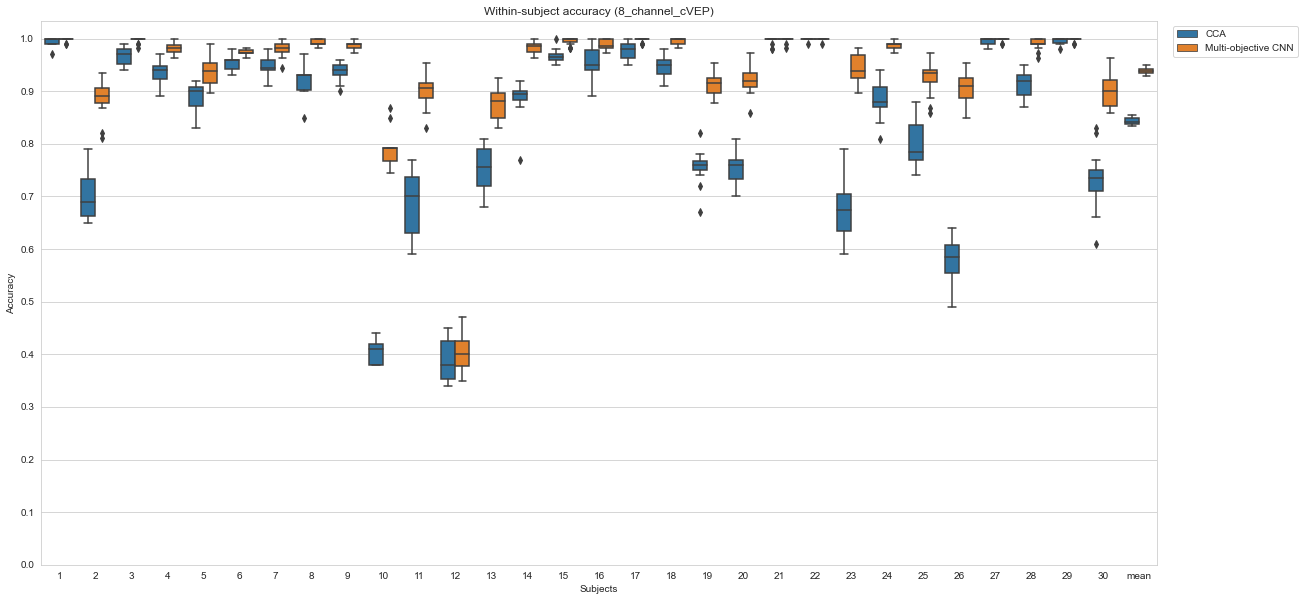

In [4]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['category_accuracy'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['category_accuracy'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")
dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Within-subject accuracy (8_channel_cVEP)')
ax.set(ylabel='Accuracy')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.01, 1.0))
plt.show()

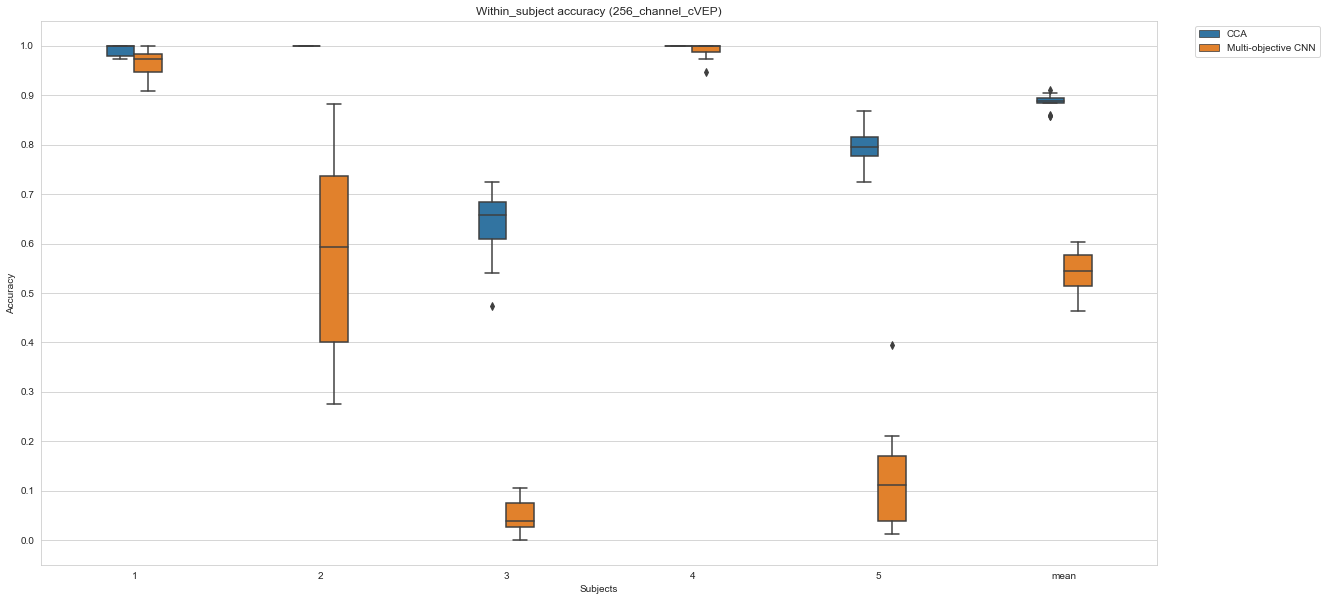

In [5]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['category_accuracy'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['category_accuracy'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")
dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Within_subject accuracy (256_channel_cVEP)')
ax.set(ylabel='Accuracy')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

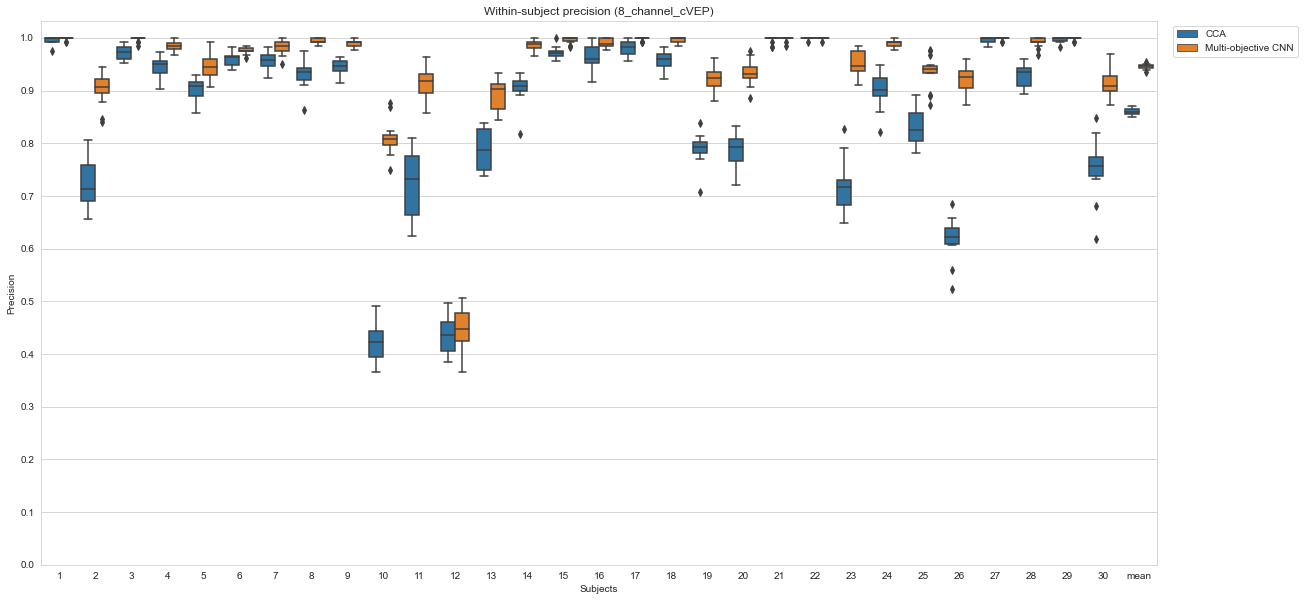

In [6]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['precision'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['precision'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Within-subject precision (8_channel_cVEP)')
ax.set(ylabel='Precision')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.01, 1.0))
plt.show()

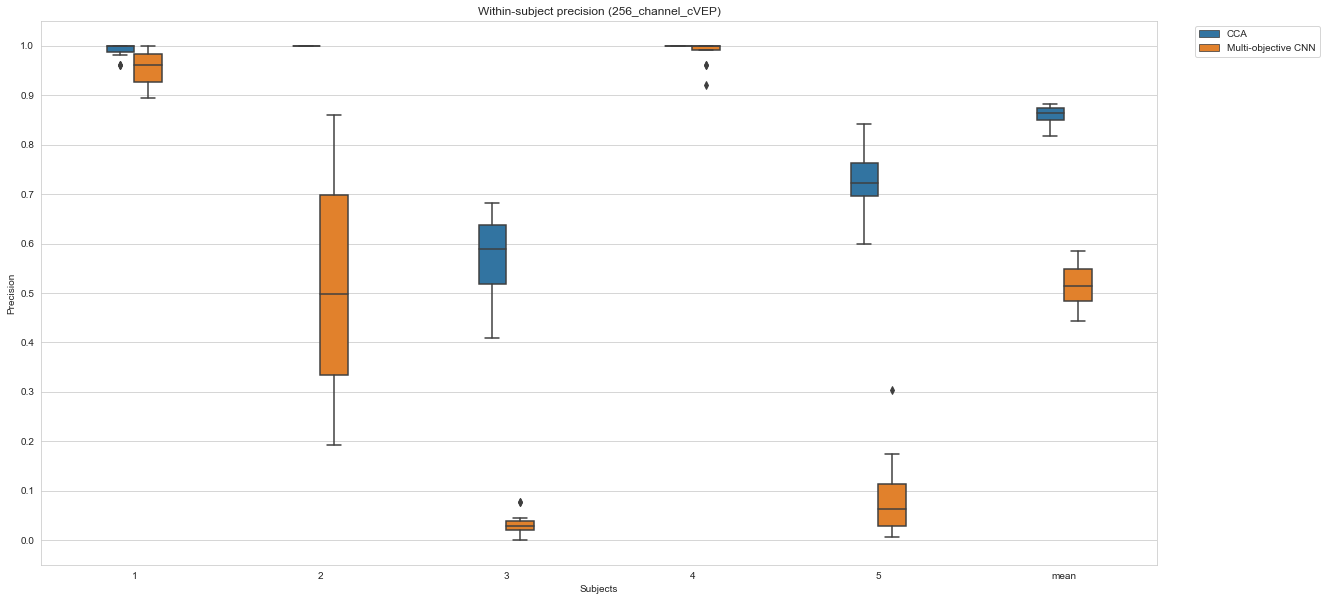

In [7]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['precision'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['precision'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Within-subject precision (256_channel_cVEP)')
ax.set(ylabel='Precision')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

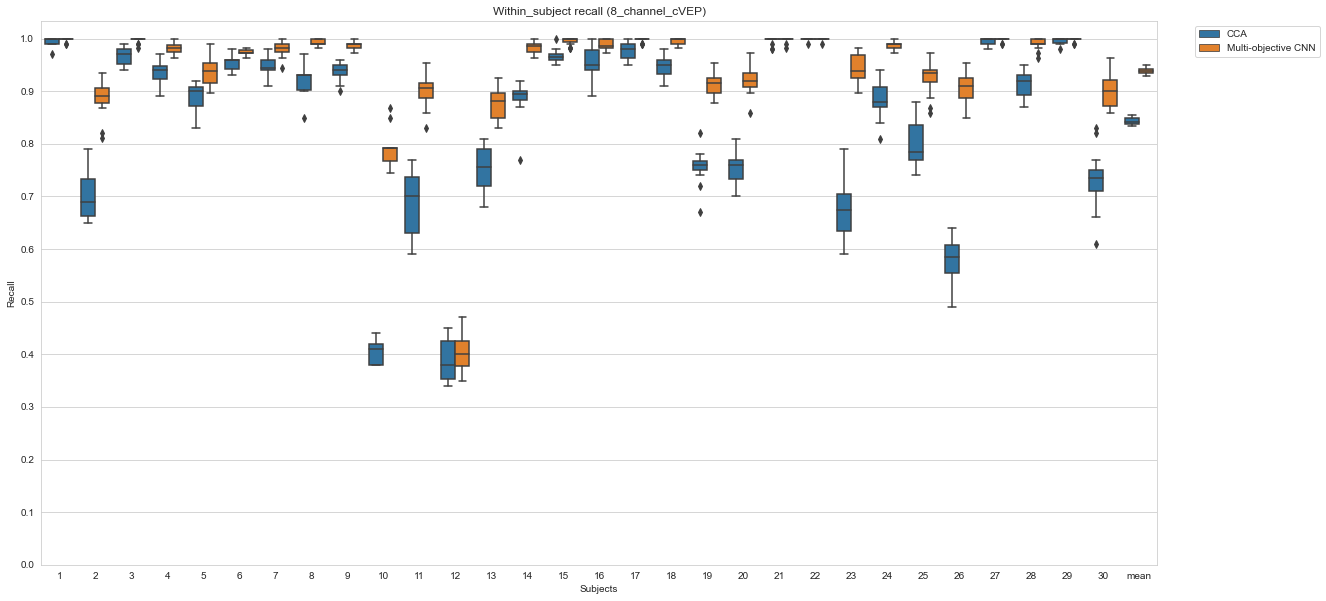

In [8]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['recall'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['recall'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Within_subject recall (8_channel_cVEP)')
ax.set(ylabel='Recall')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

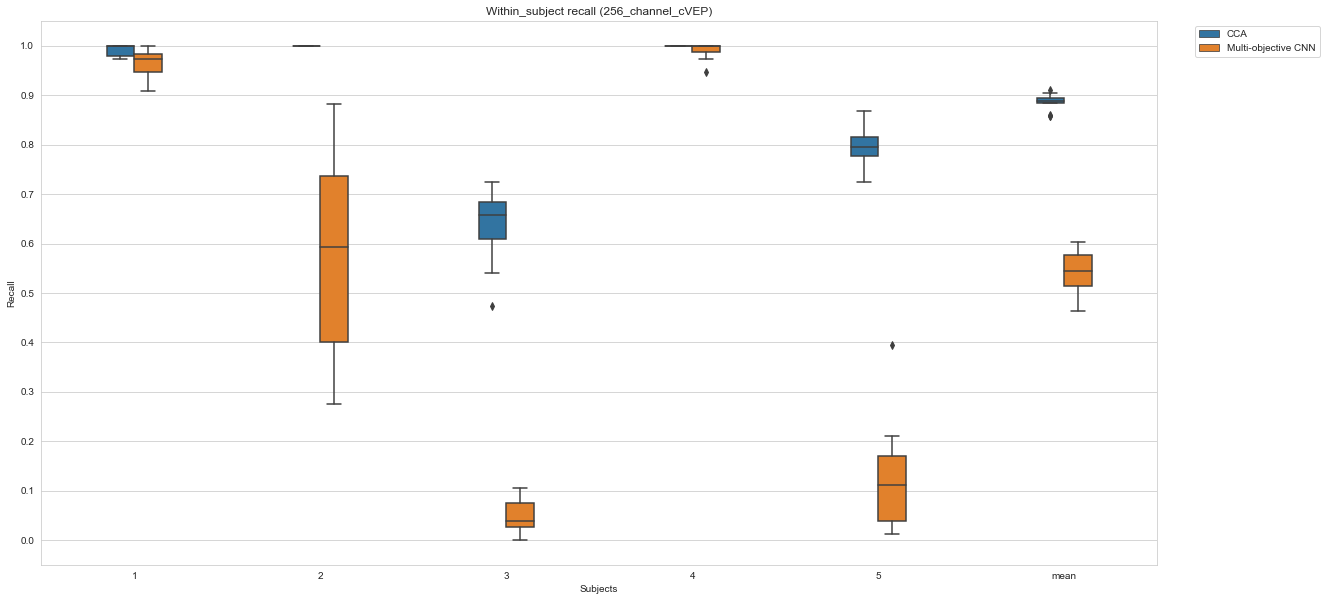

In [9]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['recall'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['recall'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Within_subject recall (256_channel_cVEP)')
ax.set(ylabel='Recall')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

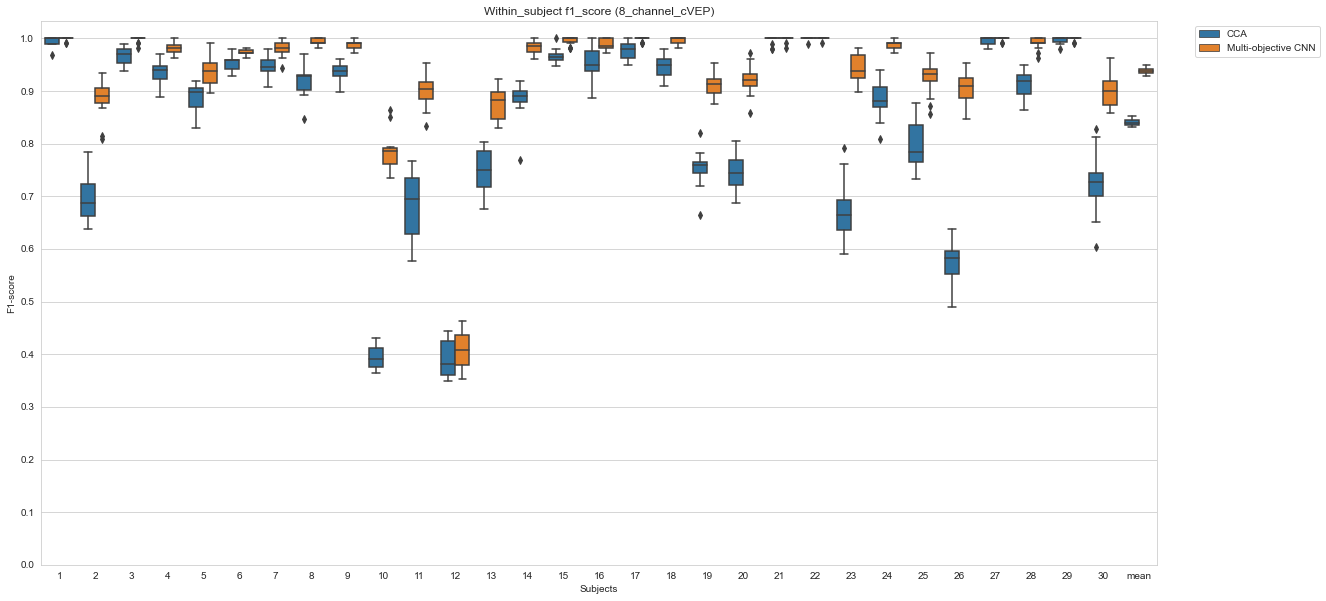

In [10]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['f1_score'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['f1_score'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Within_subject f1_score (8_channel_cVEP)')
ax.set(ylabel='F1-score')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

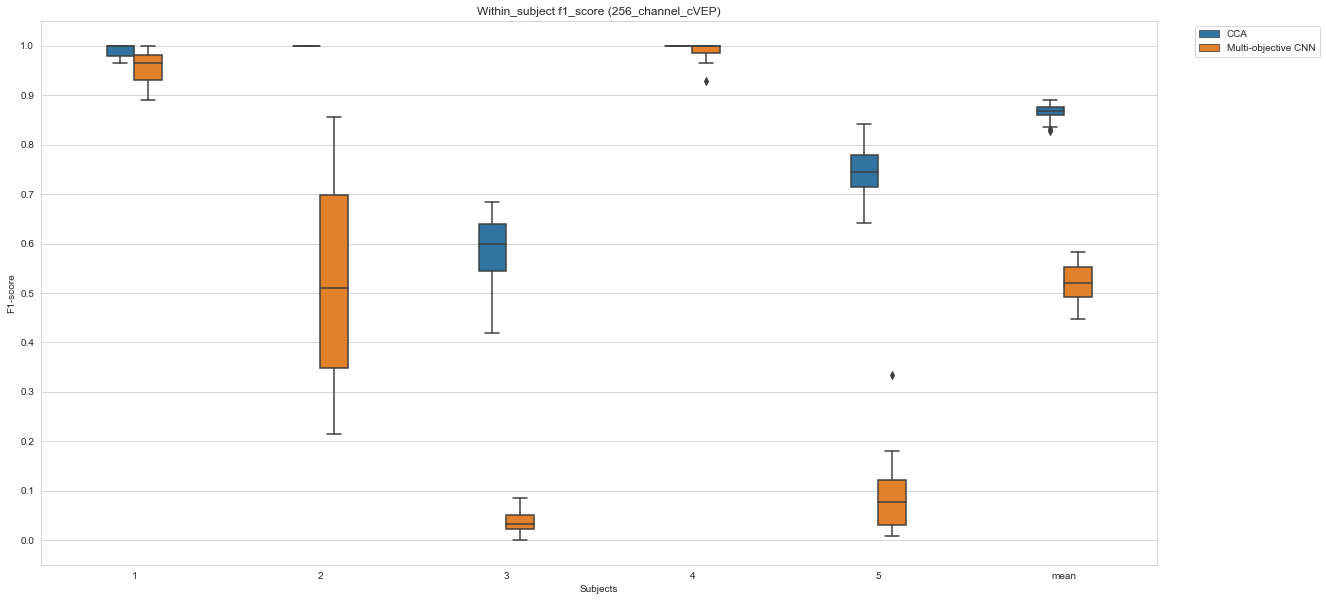

In [11]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['f1_score'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['f1_score'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Within_subject f1_score (256_channel_cVEP)')
ax.set(ylabel='F1-score')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

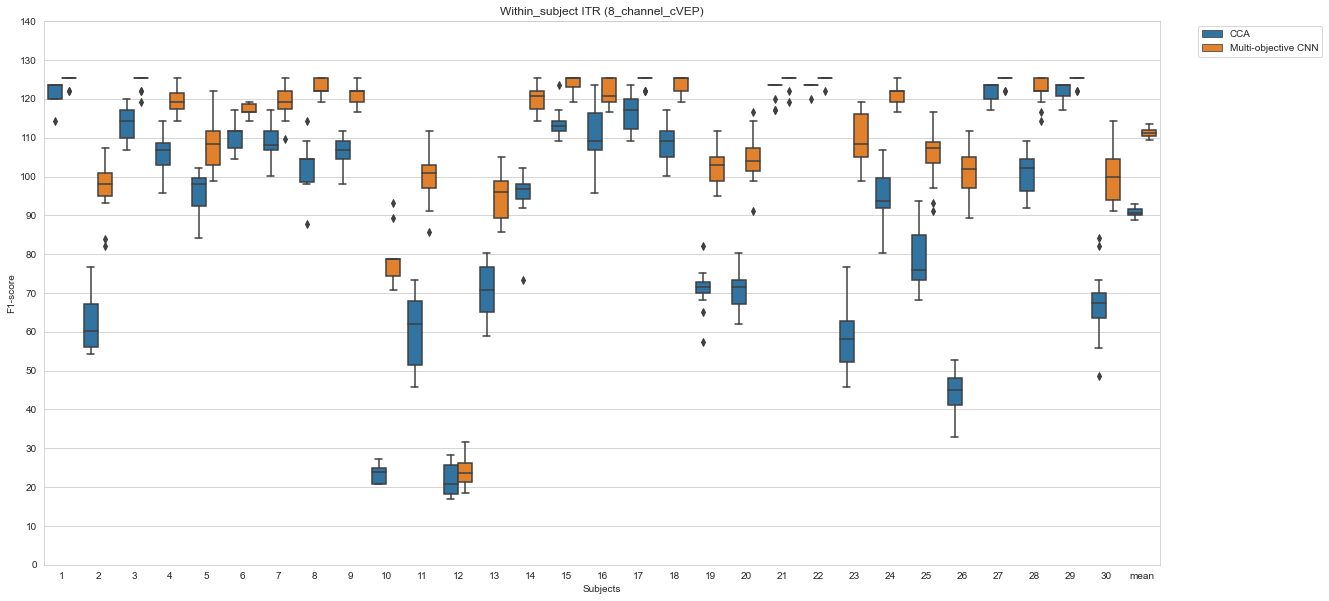

In [12]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['ITR'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['ITR'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Within_subject ITR (8_channel_cVEP)')
ax.set(ylabel='F1-score')
ax.set(yticks=np.arange(0,150,10))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

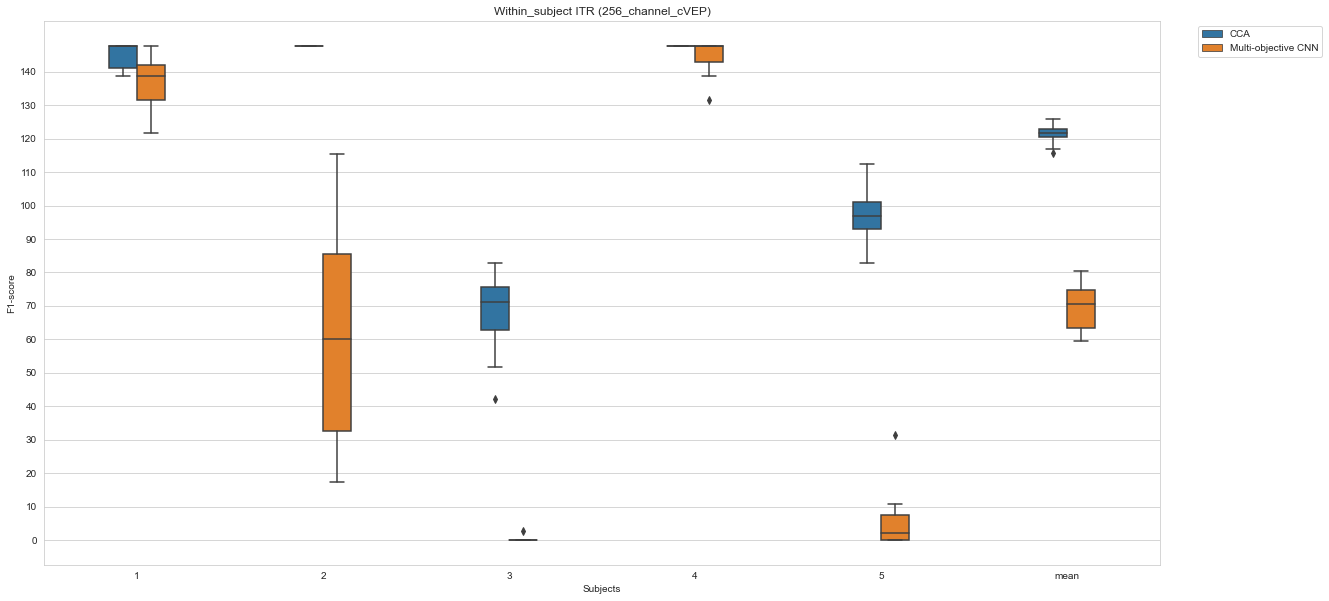

In [13]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['ITR'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['ITR'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Within_subject ITR (256_channel_cVEP)')
ax.set(ylabel='F1-score')
ax.set(yticks=np.arange(0,150,10))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

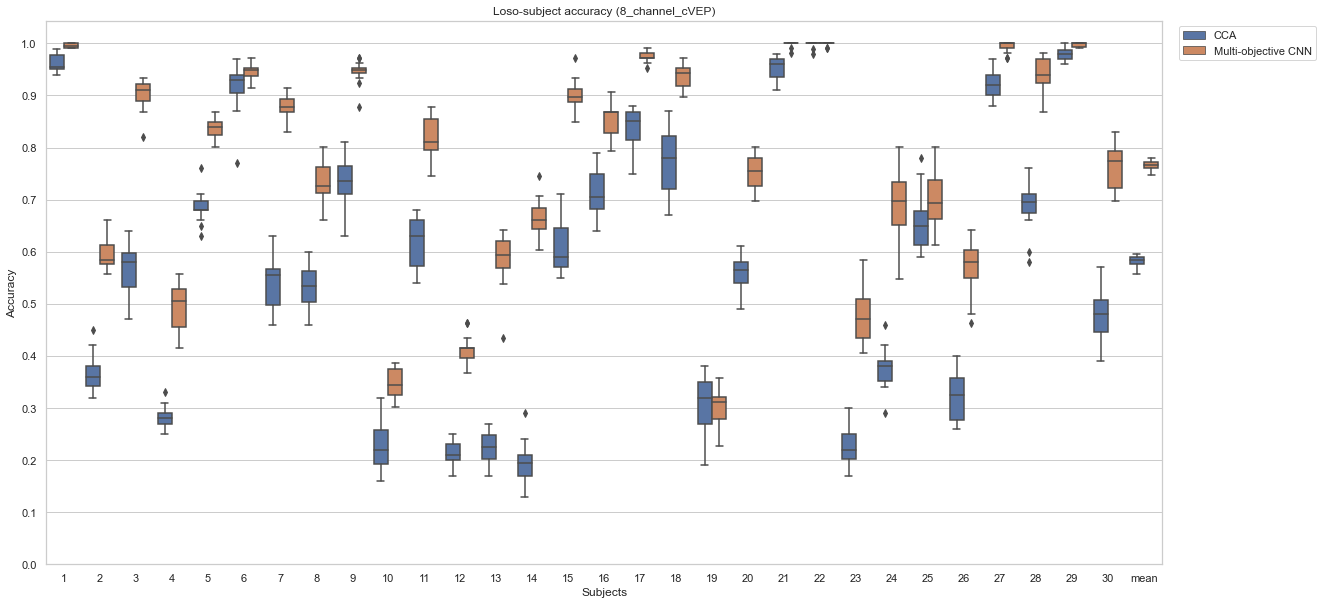

In [109]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['category_accuracy'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['category_accuracy'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")
dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Loso-subject accuracy (8_channel_cVEP)')
ax.set(ylabel='Accuracy')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.01, 1.0))
plt.show()

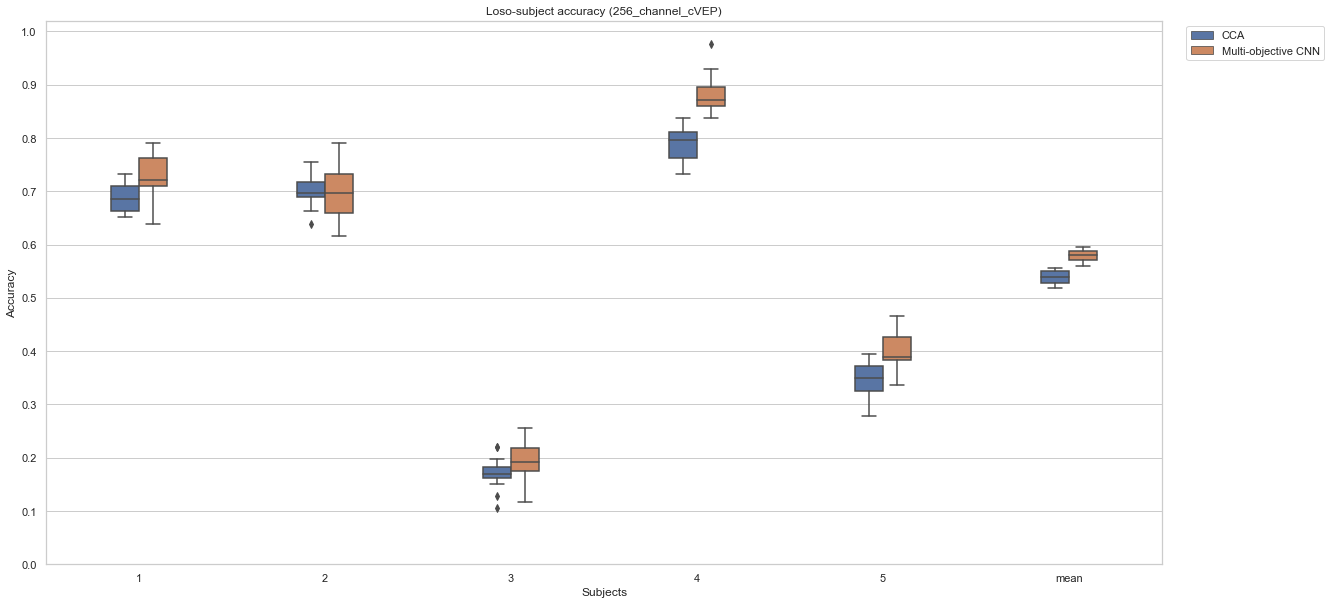

In [108]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['category_accuracy'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['category_accuracy'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")
dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Loso-subject accuracy (256_channel_cVEP)')
ax.set(ylabel='Accuracy')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

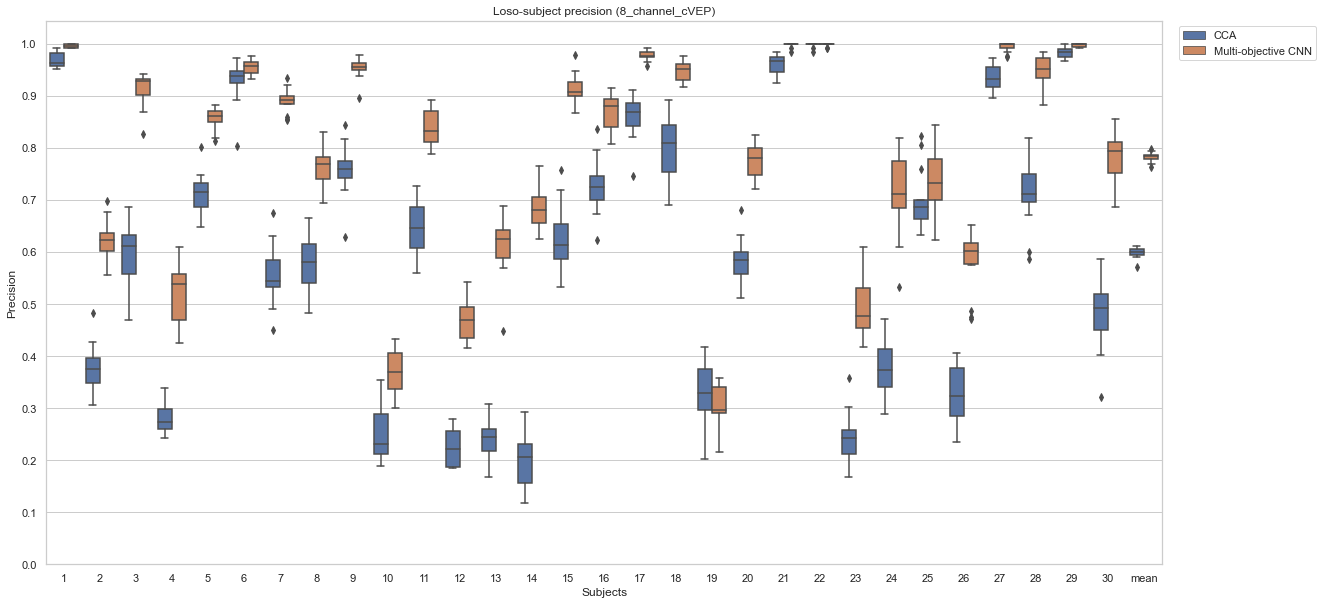

In [86]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['precision'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['precision'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Loso-subject precision (8_channel_cVEP)')
ax.set(ylabel='Precision')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.01, 1.0))
plt.show()

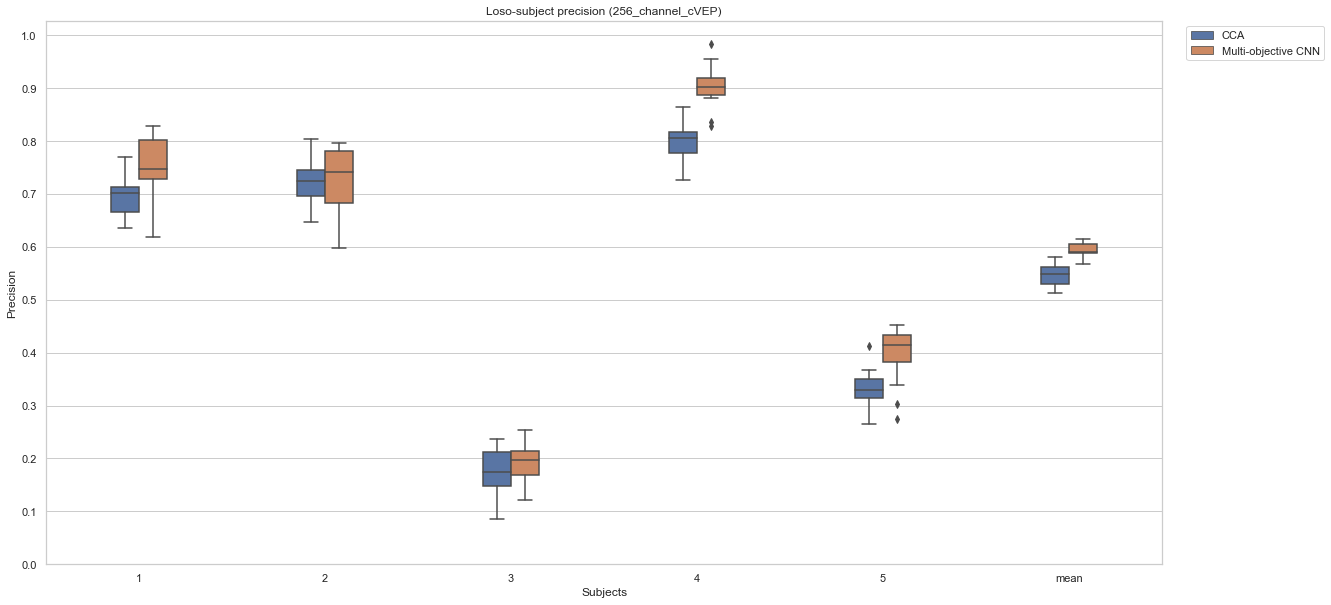

In [89]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['precision'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['precision'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Loso-subject precision (256_channel_cVEP)')
ax.set(ylabel='Precision')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

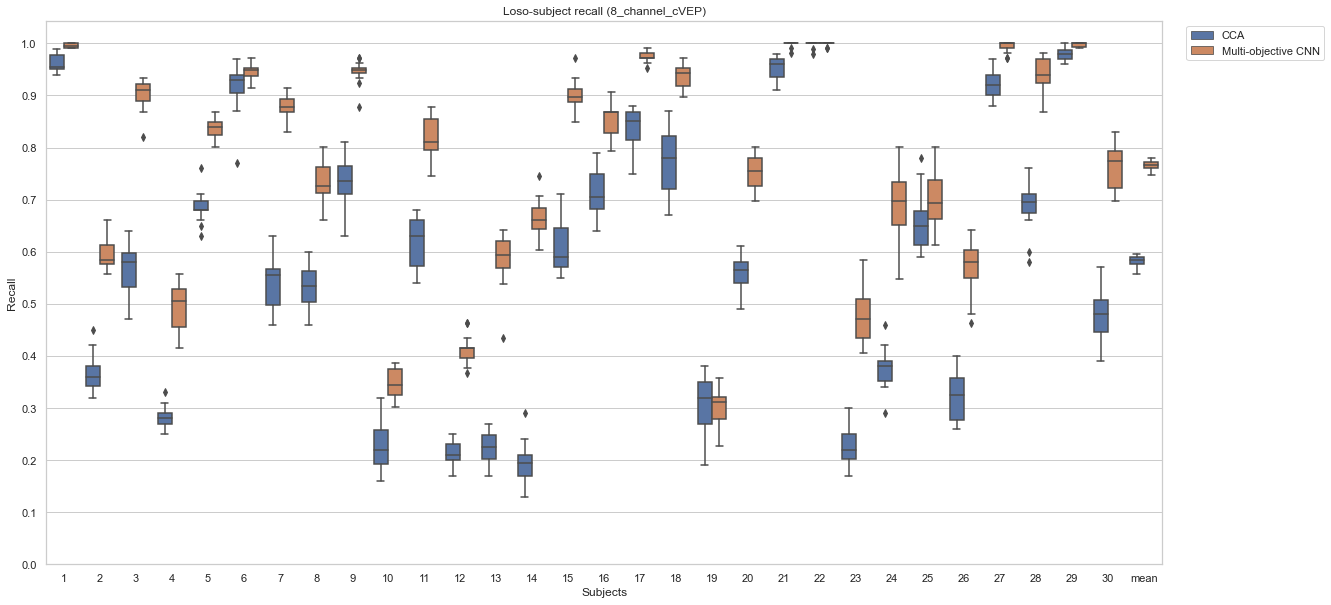

In [101]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['recall'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['recall'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Loso-subject recall (8_channel_cVEP)')
ax.set(ylabel='Recall')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

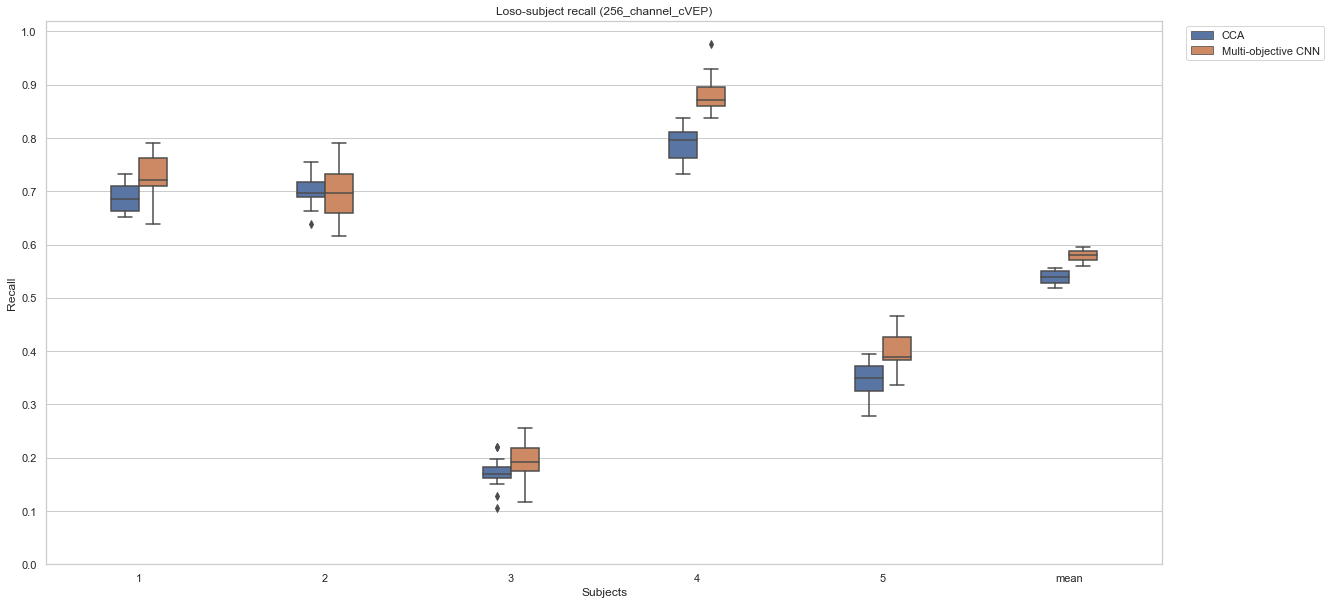

In [100]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['recall'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['recall'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Loso-subject recall (256_channel_cVEP)')
ax.set(ylabel='Recall')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

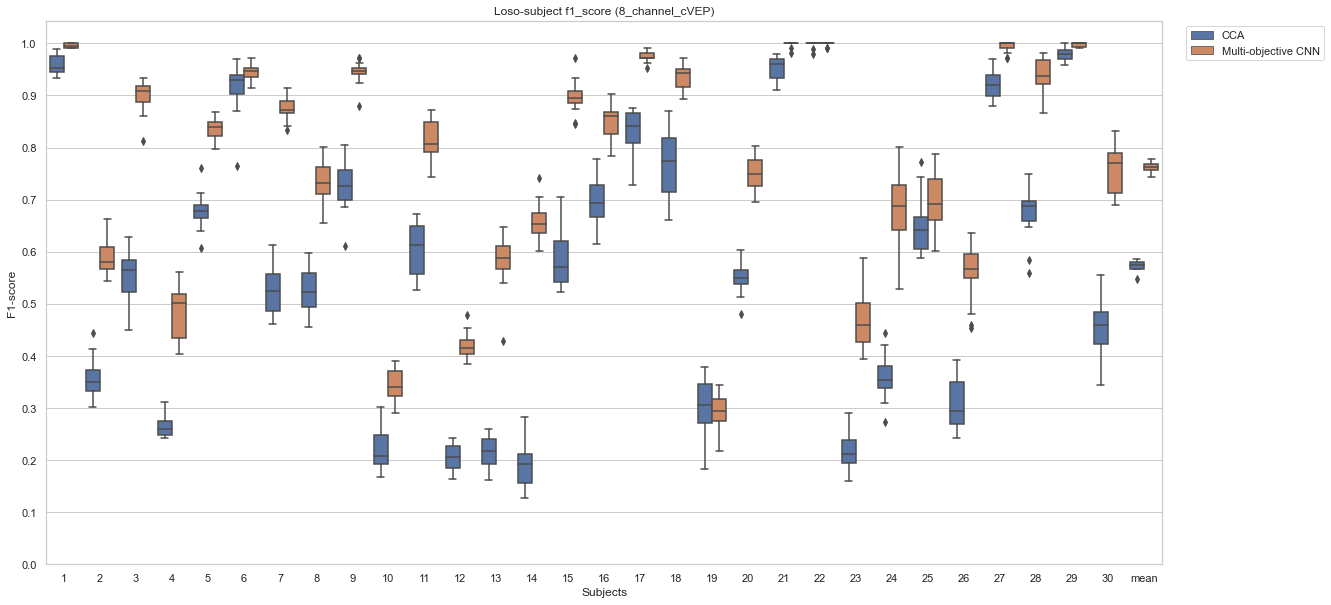

In [99]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['f1_score'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['f1_score'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Loso-subject f1_score (8_channel_cVEP)')
ax.set(ylabel='F1-score')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

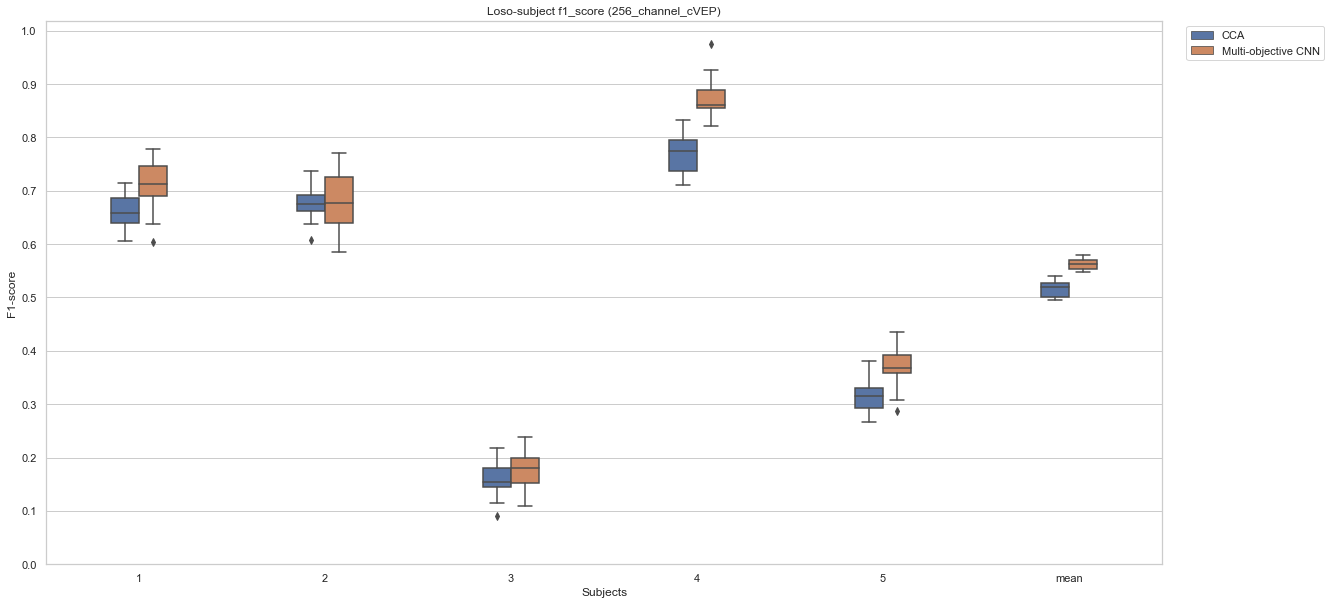

In [98]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['f1_score'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['f1_score'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Loso-subject f1_score (256_channel_cVEP)')
ax.set(ylabel='F1-score')
ax.set(yticks=np.arange(0,1.001,0.1))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

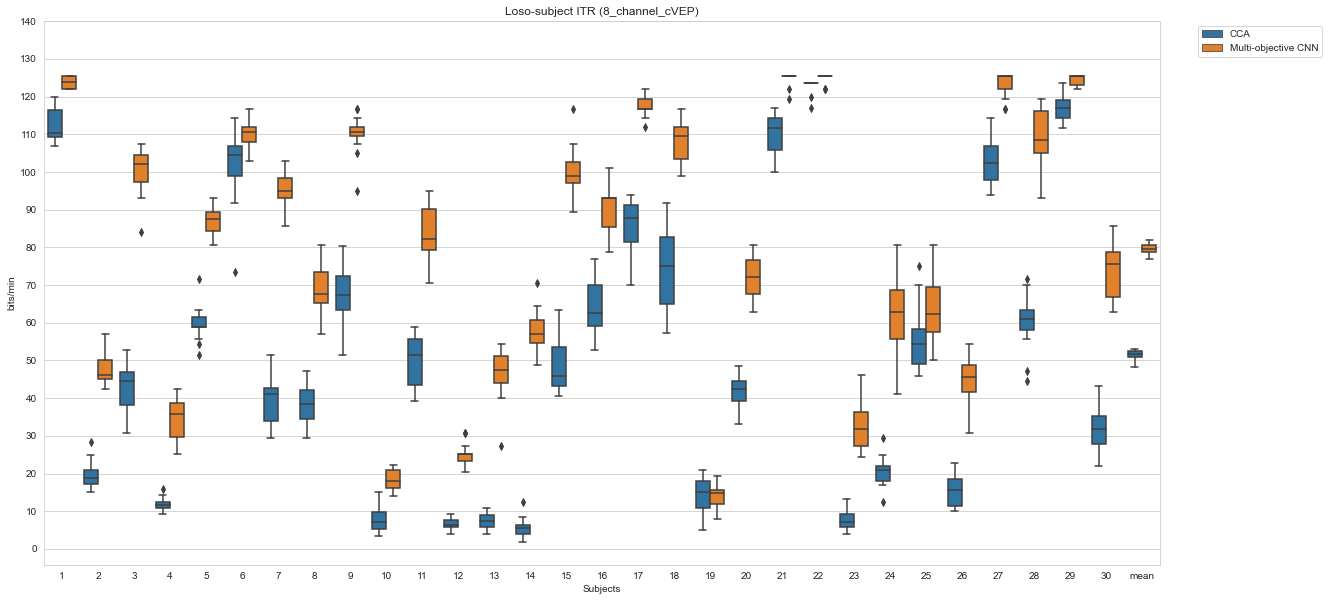

In [16]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['ITR'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['ITR'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Loso-subject ITR (8_channel_cVEP)')
ax.set(ylabel='bits/min')
ax.set(yticks=np.arange(0,150,10))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

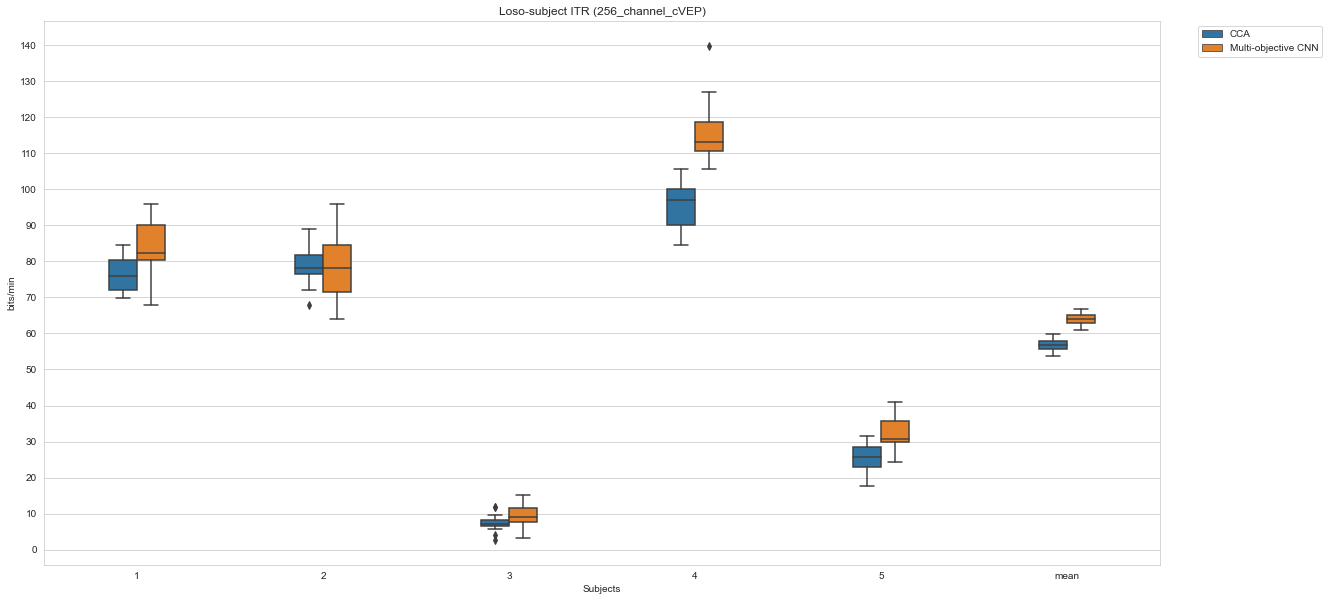

In [17]:
n_subjecs = 5
n_folds = 15

model = 'cca'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

category_acc_cca = {}
category_acc_multi_objective_cnn = {}
for s in range(1,n_subjecs+1):
    if s not in category_acc_cca.keys():
        category_acc_cca[s] = []
        category_acc_multi_objective_cnn[s] = []
    for f in range(1,n_folds+1):
        category_acc_cca[s].append(results_cca[s][f]['ITR'])
        category_acc_multi_objective_cnn[s].append(results_multi_objective_cnn[s][f]['ITR'])
    
cat_acc_arr = np.array(list(category_acc_cca.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_cca['mean'] = []
for f in range(0,15):
    category_acc_cca['mean'].append(cat_acc_mean[f])

cat_acc_arr = np.array(list(category_acc_multi_objective_cnn.values()))
cat_acc_mean = list(np.mean(cat_acc_arr, axis=0))
category_acc_multi_objective_cnn['mean'] = []
for f in range(0,15):
    category_acc_multi_objective_cnn['mean'].append(cat_acc_mean[f])
    
group = []
cca = []
multi_objective_cnn = []
for i in category_acc_cca.keys():
    category_acc_cca_list = category_acc_cca[i]
    category_acc_multi_objective_cnn_list = category_acc_multi_objective_cnn[i]
    
    for j in range(1,len(category_acc_cca_list)):
        group.append(i)
        cca.append(float(category_acc_cca_list[j]))
        multi_objective_cnn.append(float(category_acc_multi_objective_cnn_list[j]))
    

df = pd.DataFrame({'Subjects':group,'CCA':cca,'Multi-objective CNN':multi_objective_cnn})
df = df[['Subjects','CCA','Multi-objective CNN']]

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("whitegrid")

dd=pd.melt(df,id_vars=['Subjects'],value_vars=['CCA','Multi-objective CNN'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models',width=0.3)
ax.set_title('Loso-subject ITR (256_channel_cVEP)')
ax.set(ylabel='bits/min')
ax.set(yticks=np.arange(0,150,10))
ax.legend(bbox_to_anchor=(1.15, 1.0))
plt.show()

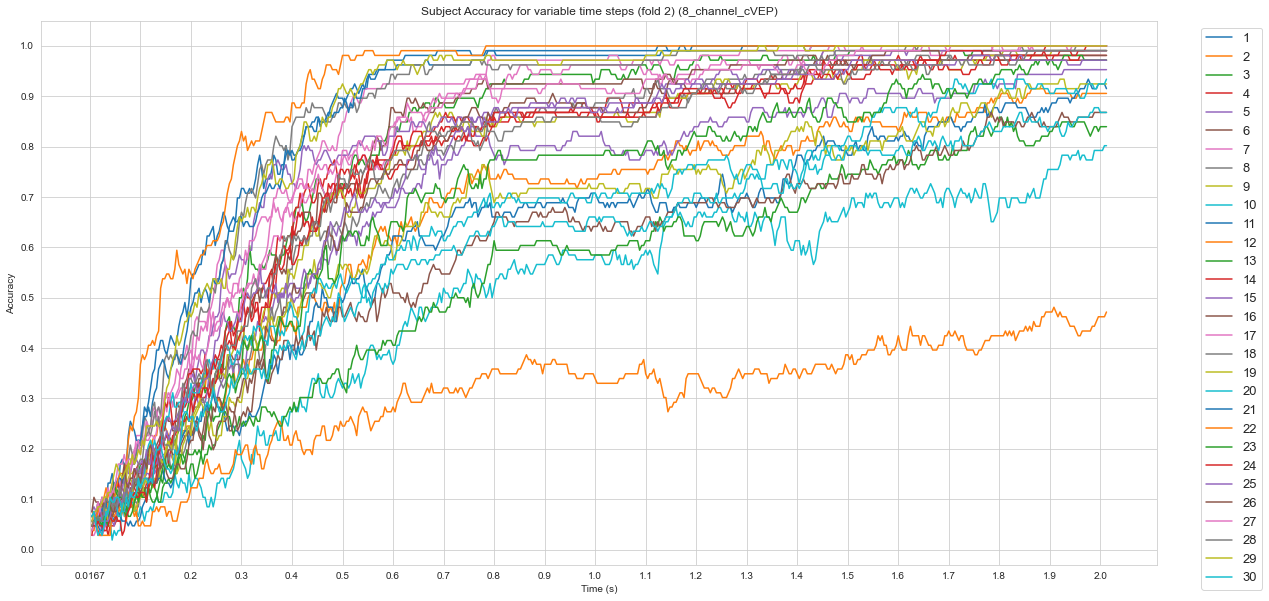

In [30]:
n_subjecs = 30
n_folds = 15

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

f = 2
plt.figure(figsize=(20,10))
for s in range(1,n_subjecs+1):
    time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
    time.insert(0,0.0167)
    plt.plot(np.arange(0,504)[1:],results_multi_objective_cnn[s][f]['variable_time_steps'][1:], label=s)
plt.xticks(np.arange(0,504,25), time)
plt.yticks(np.arange(0,1.01,0.1))
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.title('Subject Accuracy for variable time steps (fold {}) ({})'.format(f,dataset))
plt.legend(fontsize=13,bbox_to_anchor=(1.1, 1))
plt.show()

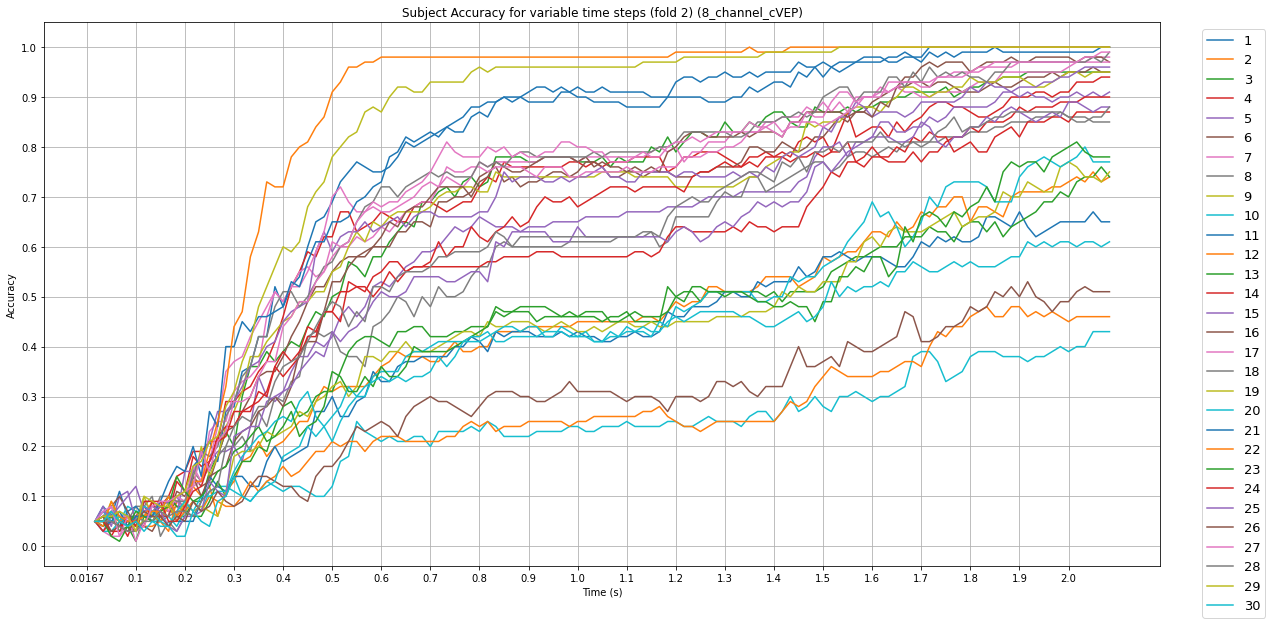

In [16]:
n_subjecs = 30
n_folds = 15

model = 'cca'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_cca = pickle.load(handle)

f = 2
plt.figure(figsize=(20,10))
for s in range(1,n_subjecs+1):
    time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
    time.insert(0,0.0167)
    plt.plot(np.arange(0,126)[1:],results_cca[s][f]['variable_time_steps'][1:], label=s)
plt.xticks(np.arange(0,126,6), time)
plt.yticks(np.arange(0,1.01,0.1))
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.title('Subject Accuracy for variable time steps (fold {}) ({})'.format(f,dataset))
plt.legend(fontsize=13,bbox_to_anchor=(1.1, 1))
plt.grid()
plt.show()

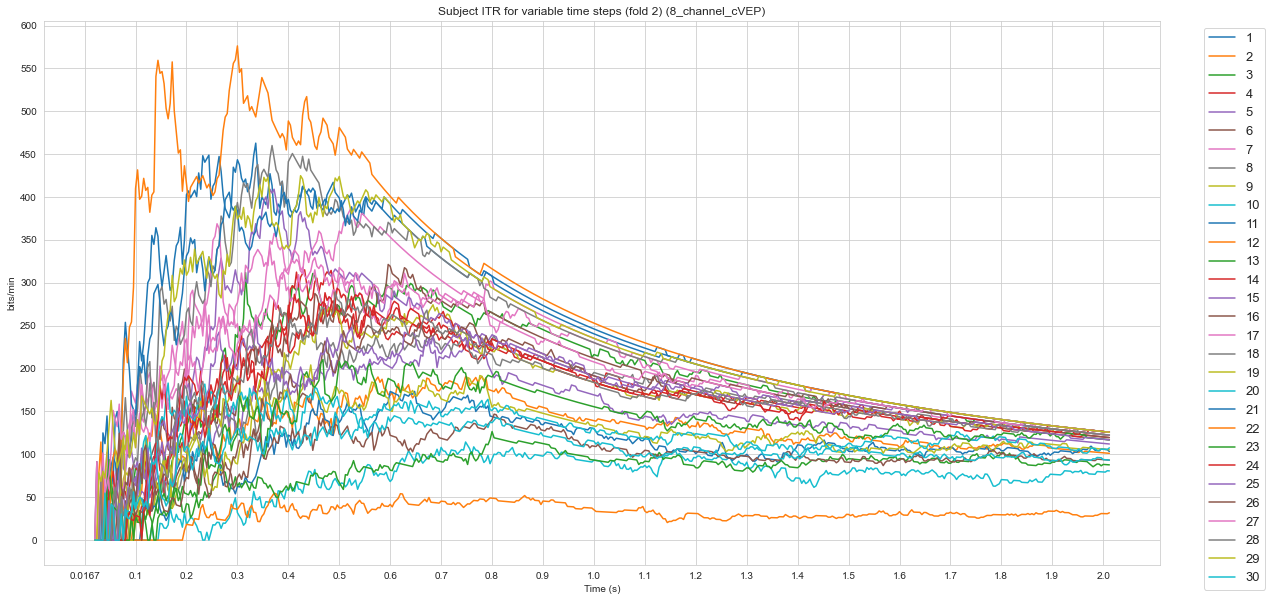

In [43]:
n_subjecs = 30
n_folds = 15

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

f = 2
plt.figure(figsize=(20,10))
for s in range(1,n_subjecs+1):
    time = list(np.round(np.arange(0,2.1,0.1),2)[1:])
    time.insert(0,0.0167)
    plt.plot(np.arange(0,504)[5:],results_multi_objective_cnn[s][f]['ITR_time_steps'][5:], label=s)
plt.xticks(np.arange(0,504,25), time)
plt.yticks(np.arange(0,601,50))
plt.xlabel('Time (s)')
plt.ylabel('bits/min')
plt.title('Subject ITR for variable time steps (fold {}) ({})'.format(f,dataset))
plt.legend(fontsize=13,bbox_to_anchor=(1.1, 1))
plt.show()

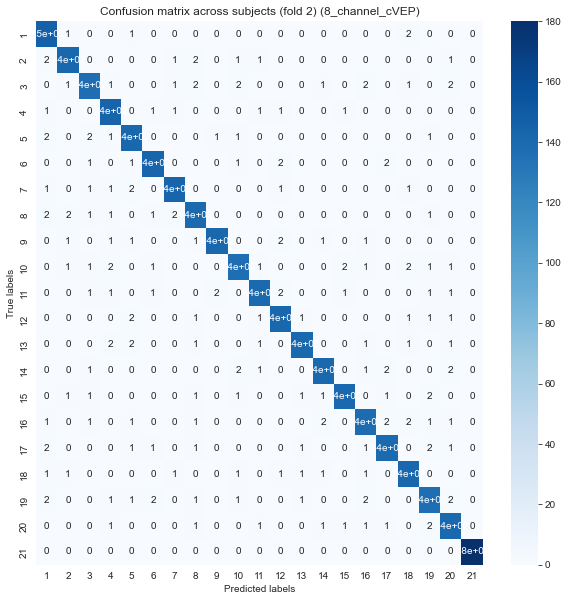

In [67]:
n_subjecs = 30
n_folds = 15
cm_all = np.zeros((30*15,21,21))
model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

c=0
for subj in range(1,31):
    cm = results_multi_objective_cnn[subj][2]['category_cm']
    cm_all[c]= cm.astype('int')
    c+=1
        
cm_all = np.sum(cm_all,axis=0)  
plt.figure(figsize=(10,10))
labels = np.arange(1,22)
cm_plot = sns.heatmap(cm_all, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
cm_plot.set(xlabel='Predicted labels', ylabel='True labels')
plt.title('Confusion matrix across subjects (fold {}) ({})'.format(2,dataset))
plt.show()

In [76]:
import numpy as np
from matplotlib.patches import PathPatch

                        
def plot_box_plot(model1,model2, group,group1,group2,mode1):
    df = pd.DataFrame({'Subjects':group,model1:group1,model2:group2})
    df = df[['Subjects',model1,model2]]

    fig, ax = plt.subplots(figsize=(20, 10))
    sns.set_style("whitegrid")
    dd=pd.melt(df,id_vars=['Subjects'],value_vars=[model1,model2],var_name='Models')
    ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
    ax.set_title('{} accuracy'.format(mode1))
    ax.set(ylabel='Accuracy')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0,1.01,0.1))
    plt.show()

def plot_roc_curve(results, n_subjects, n_classes, model, dataset):
    for subj in range(1,n_subjects+1):
        fpr = results['fpr'][subj]
        tpr = results['tpr'][subj]
        roc_auc = results['auc'][subj]
        plt.figure(figsize=(10, 10))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], lw=1.5,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i+1, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for subject {}'.format(subj))
        plt.legend(bbox_to_anchor=(1.05, 1.0))
        plt.show()

        
def mean_no_none(l):
    l_no_none = [el for el in l if el is not None]
    return sum(l_no_none) / len(l_no_none)

def aggregate_dicts(dicts, operation=lambda x: sum(x) / len(x)):
    """
    Aggregate a sequence of dictionaries to a single dictionary using `operation`. `Operation` should
    reduce a list of all values with the same key. Keyrs that are not found in one dictionary will
    be mapped to `None`, `operation` can then chose how to deal with those.
    """
    all_keys = set().union(*[el.keys() for el in dicts])
    return {k: operation([dic.get(k, None) for dic in dicts]) for k in all_keys}

def fix_roc(results,n_subjects):
    for i in range(1,n_subjects+1):
        for j in range(1,16):
            fpr_f = results[i][j]['fpr']
            tpr_f = results[i][j]['tpr']
            for k in fpr_f.keys():
                if(len(fpr_f[k])<3):
                    fpr_f[k] = np.array([0,0,1])
                    results[i][j]['fpr'] = fpr_f
                if(len(tpr_f[k])<3):
                    tpr_f[k] = np.array([0,0,1])
                    results[i][j]['tpr'] = tpr_f
    return results

def group_results(results,n_subjects):
    group = []
    category_accuracy = []
    sequence_accuracy = []
    ITR = []
    recall_all = []
    precision_all = []
    f1_score_all = []
    results_grouped = {}
    
    fpr_all = []
    tpr_all = []
    
    results_grouped['fpr'] = {}
    results_grouped['tpr'] = {}
    results_grouped['auc'] = {}
    for i in range(1,n_subjects+1):
        results_cv = results[i] 
        if 'history' in results_cv.keys():
            results_cv_len= len(results_cv)-1
        else:
            results_cv_len= len(results_cv)
        
        fpr_subj = []
        tpr_subj = []
        auc_subj = []
        
        for j in range(1,results_cv_len+1):
            group.append(i)
            category_accuracy.append(float(results_cv[j]['category_accuracy']))
            
            
            ITR.append(float(results_cv[j]['ITR']))

            if(model == 'multi_objective_cnn'):
                sequence_accuracy.append(float(results_cv[j]['sequence_accuracy']))
            
            cm = results[i][j]['category_cm']
            recall = float(results[i][j]['recall'])
            precision = float(results[i][j]['precision'])
            f1_score = float(results[i][j]['f1_score'])
            recall_all.append(recall)
            precision_all.append(precision)
            f1_score_all.append(f1_score)
        
            fpr_subj.append(results_cv[j]['fpr'])
            tpr_subj.append(results_cv[j]['tpr'])
            auc_subj.append(results_cv[j]['auc'])
            
        fpr_all = aggregate_dicts(fpr_subj, operation= mean_no_none)
        tpr_all = aggregate_dicts(tpr_subj, operation= mean_no_none)
        auc_all = aggregate_dicts(auc_subj, operation= mean_no_none) 
        
        results_grouped['fpr'][i] = fpr_all
        results_grouped['tpr'][i] = tpr_all
        results_grouped['auc'][i] = auc_all
    
    results_grouped['group'] = group            
    results_grouped['category_accuracy'] = category_accuracy
    results_grouped['sequence_accuracy'] = sequence_accuracy
    results_grouped['ITR'] = ITR
    results_grouped['recall'] = recall_all
    results_grouped['precision'] = precision_all
    results_grouped['f1_score'] = f1_score_all

    return results_grouped

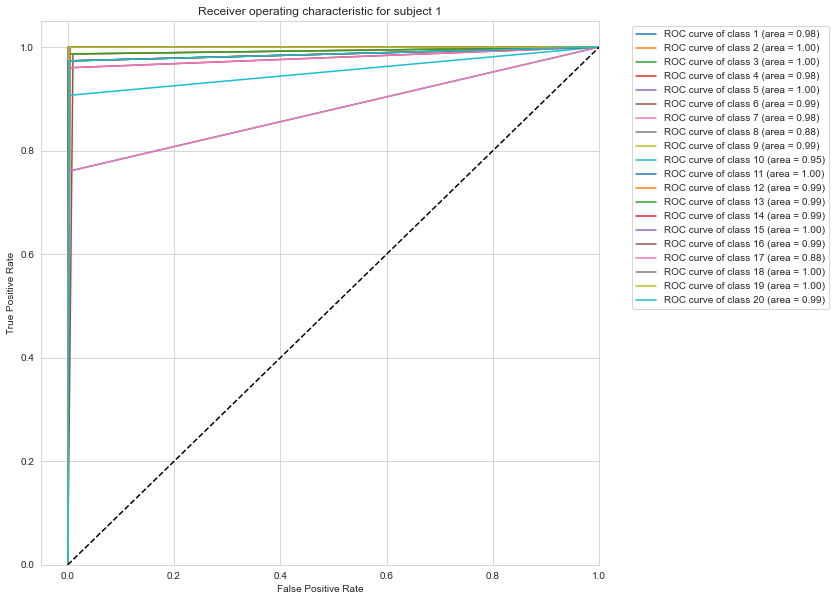

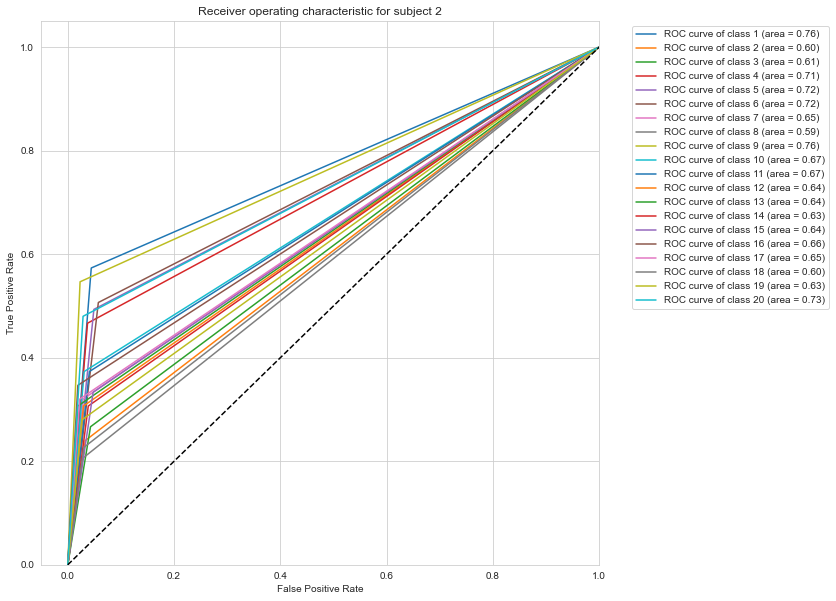

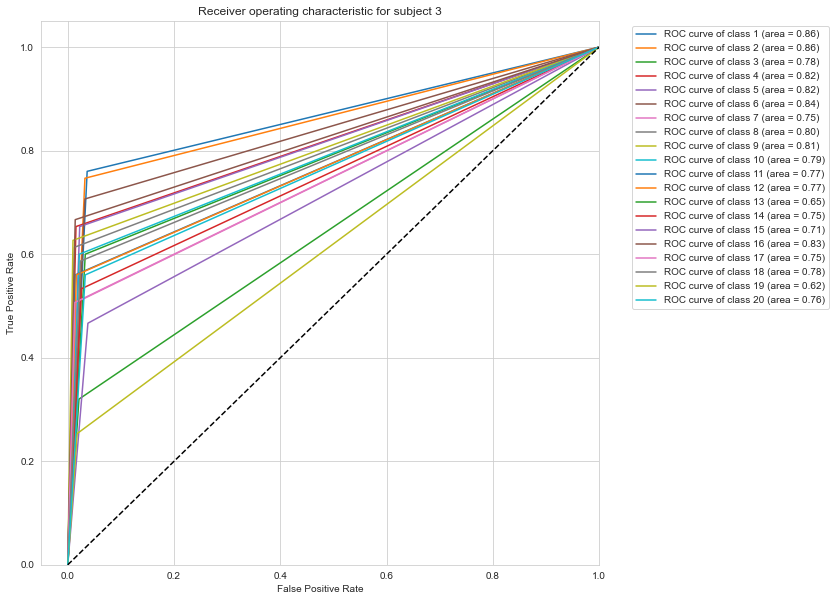

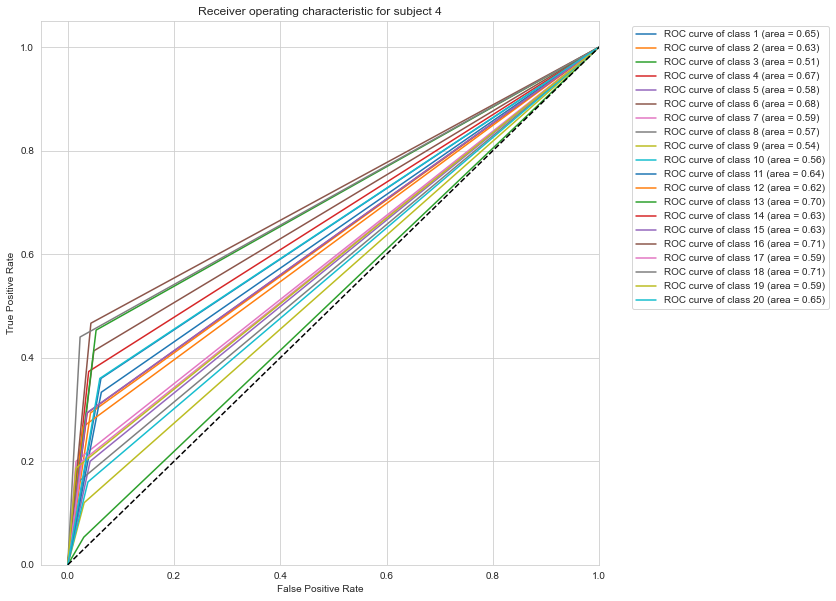

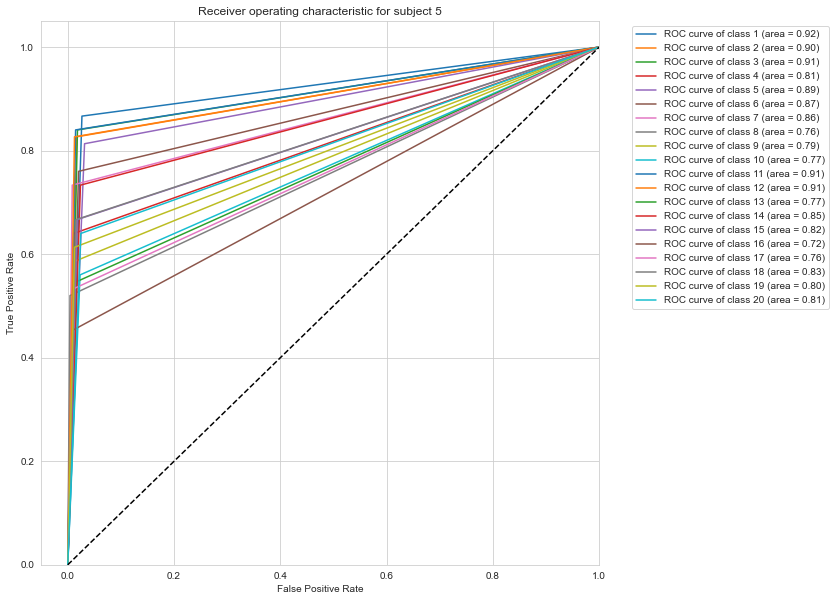

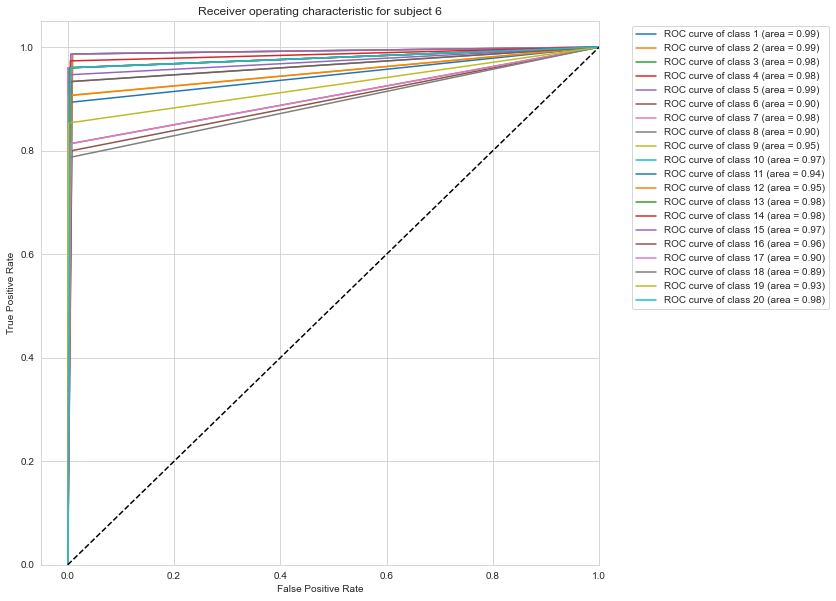

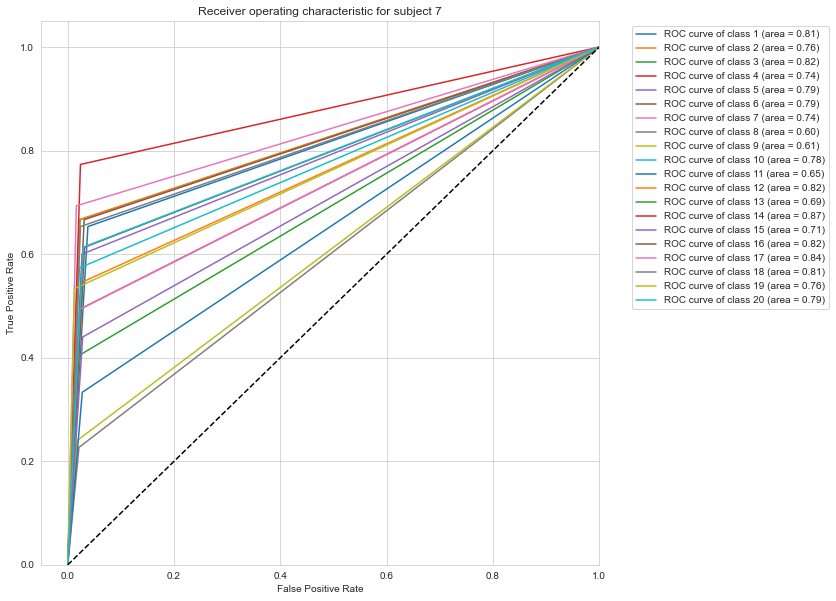

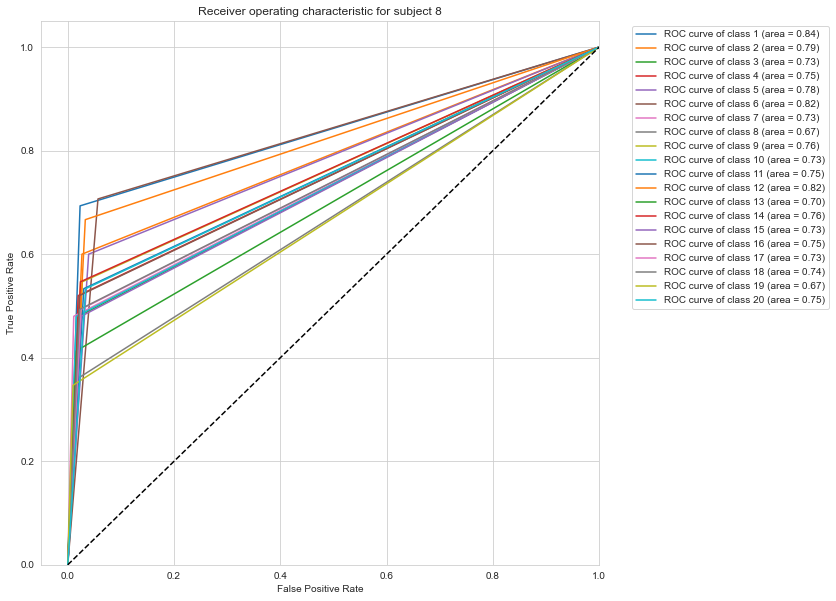

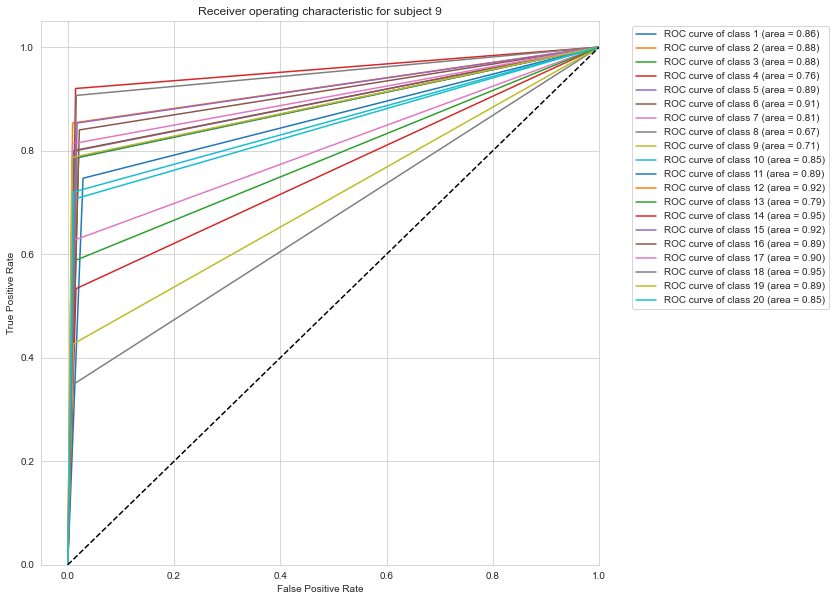

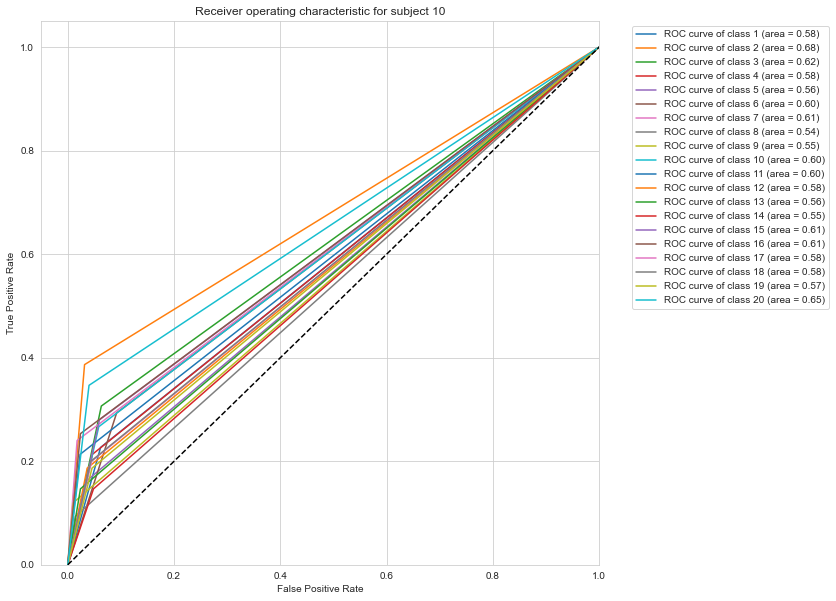

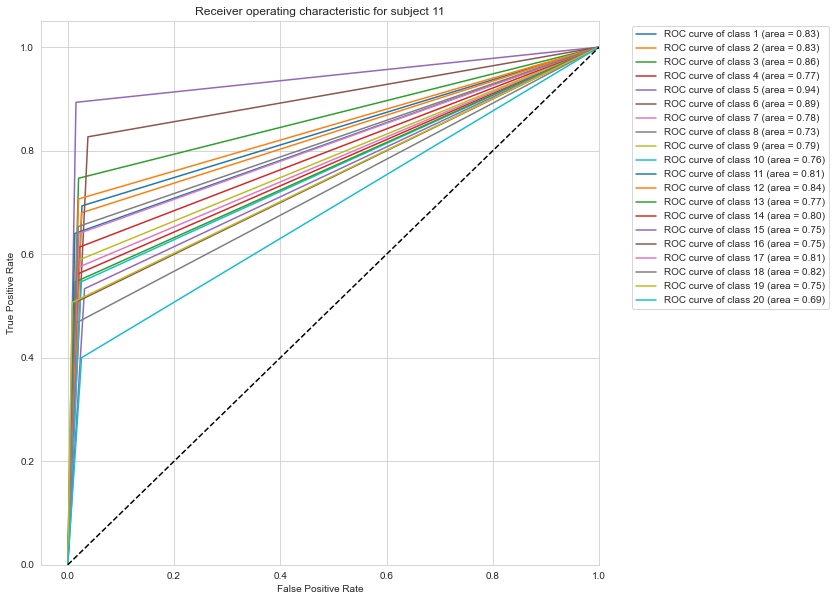

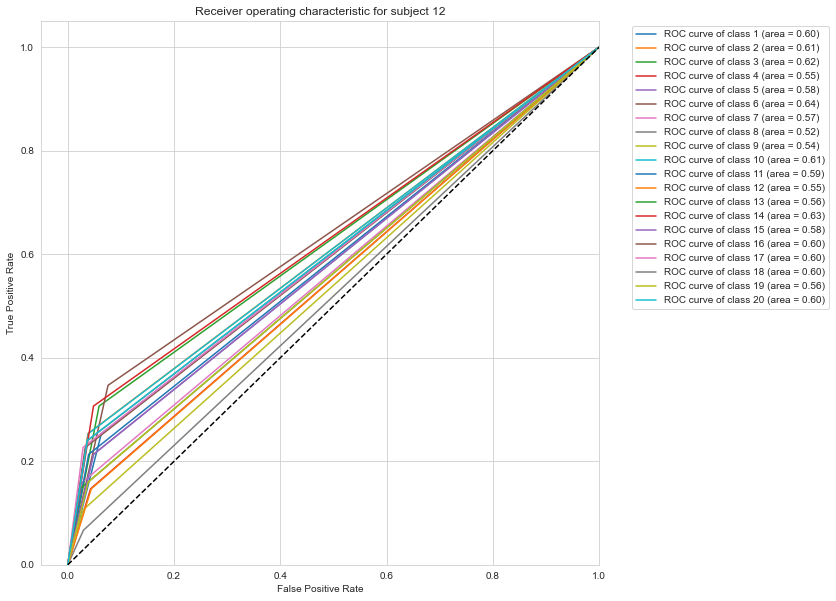

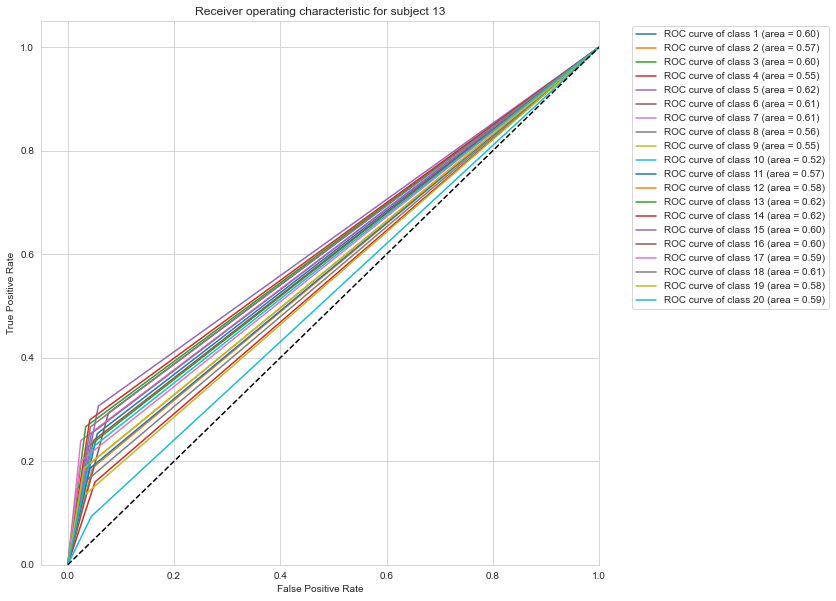

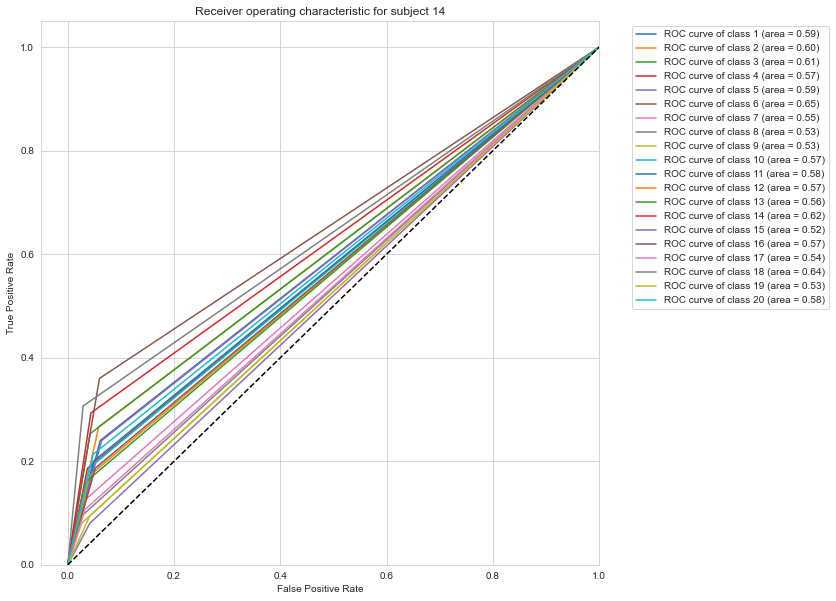

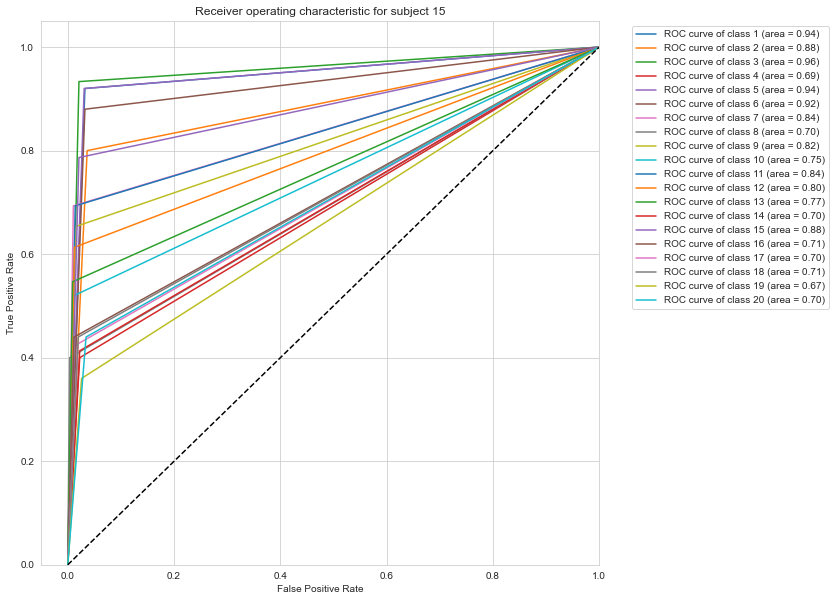

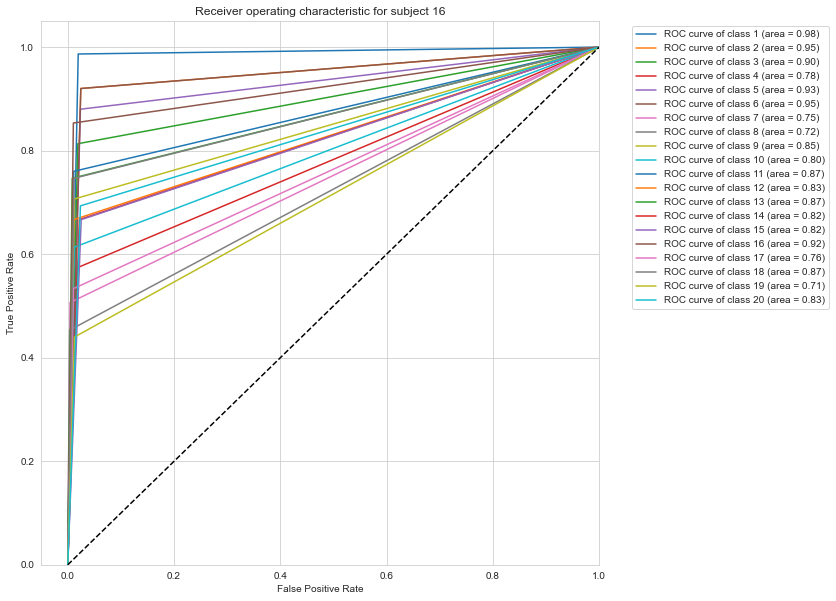

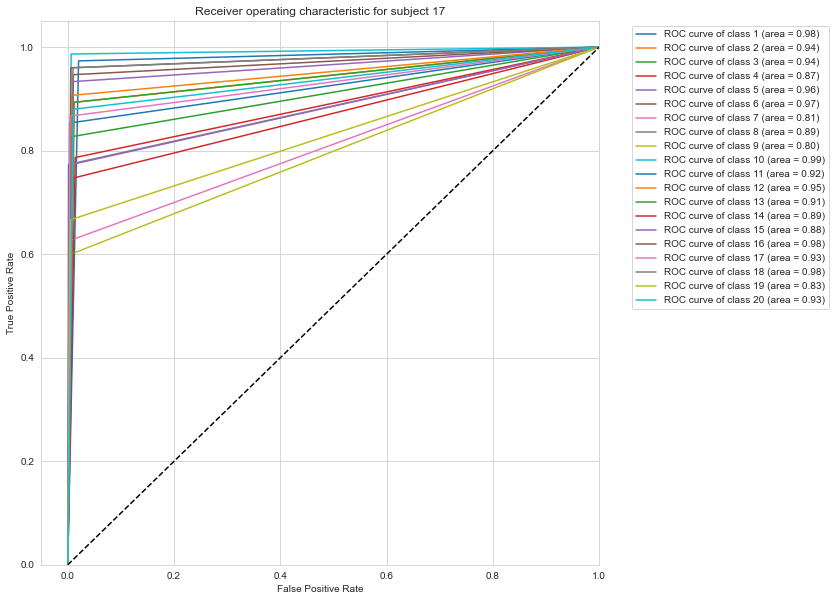

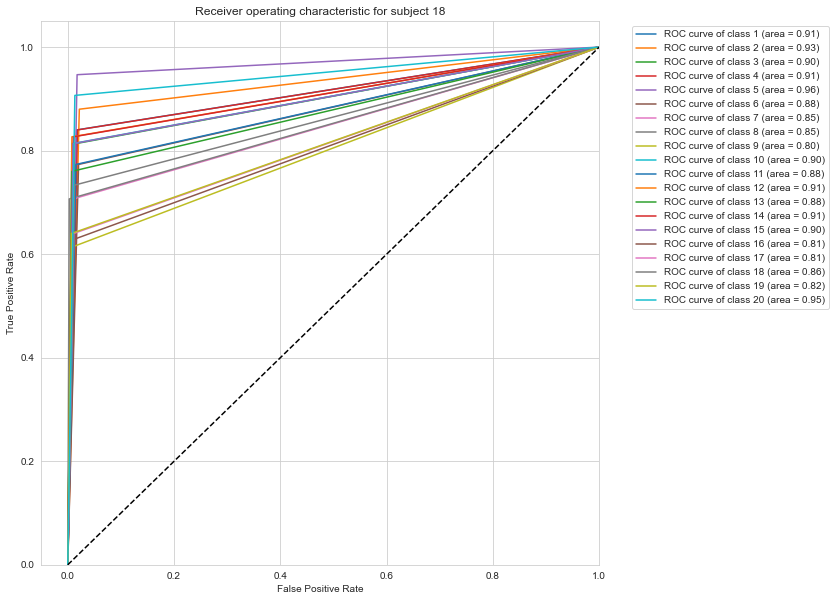

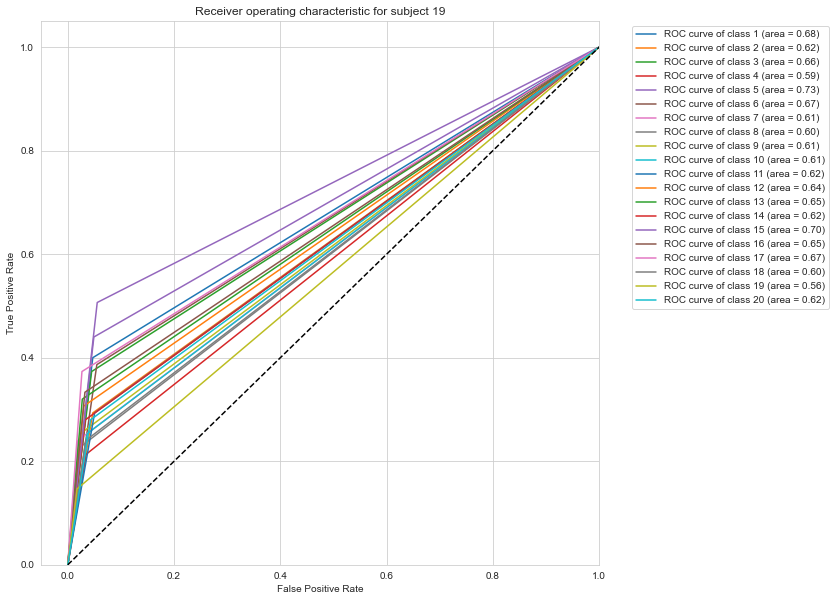

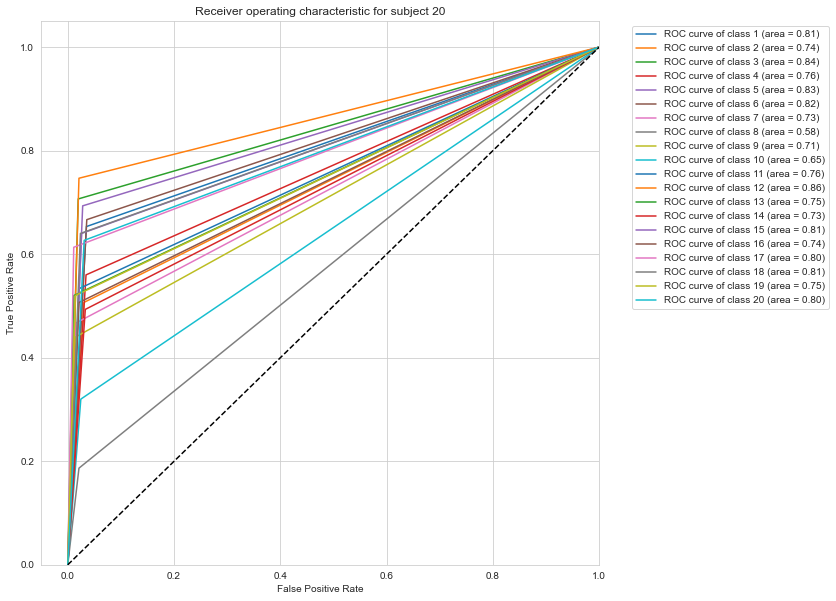

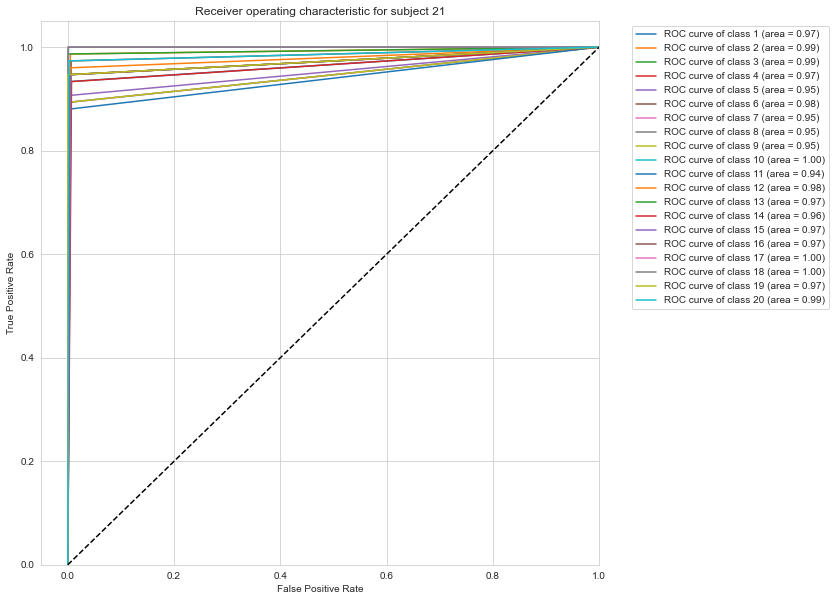

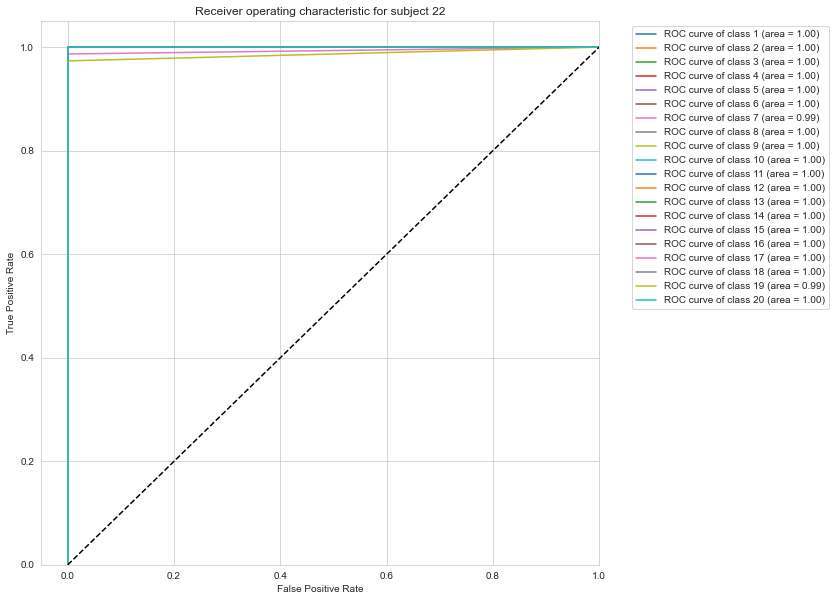

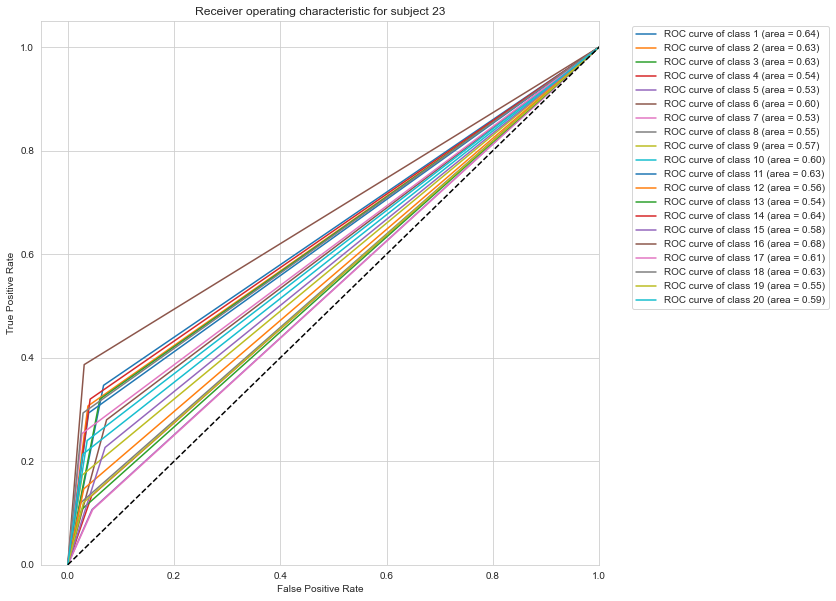

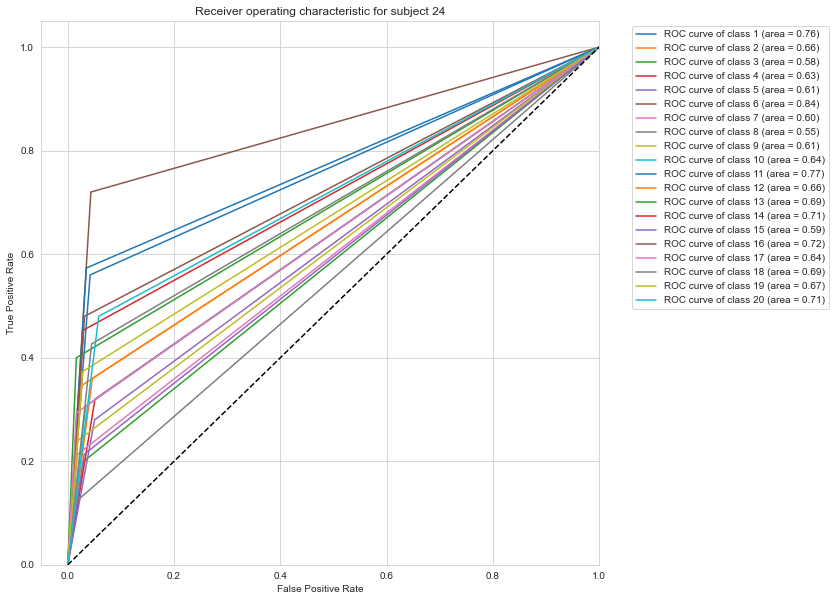

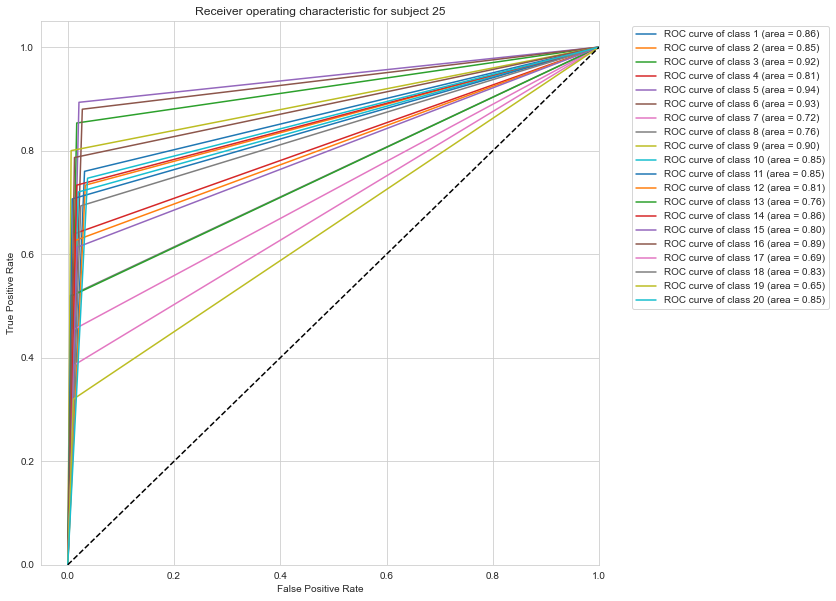

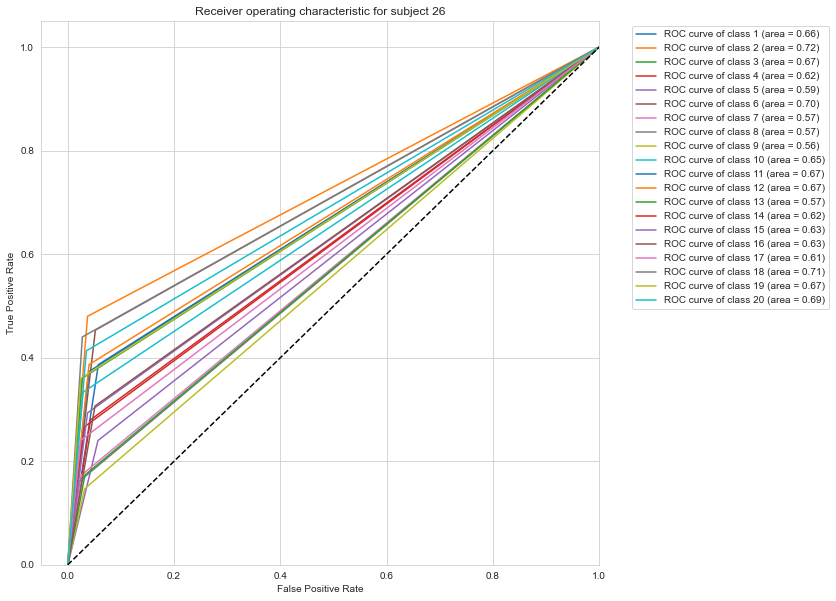

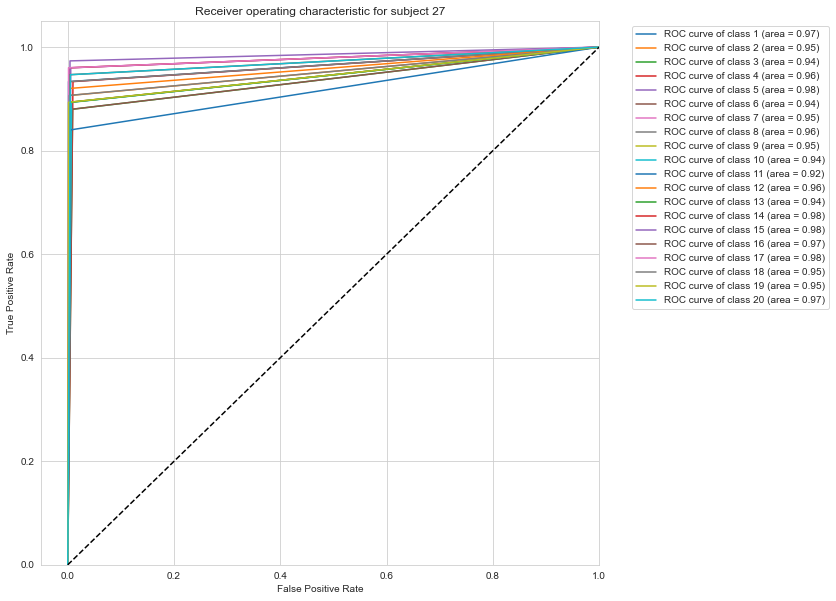

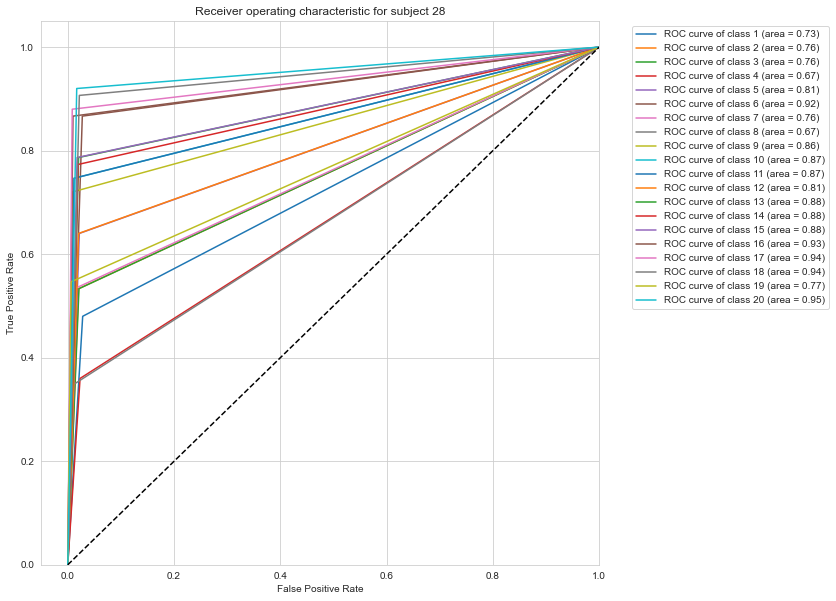

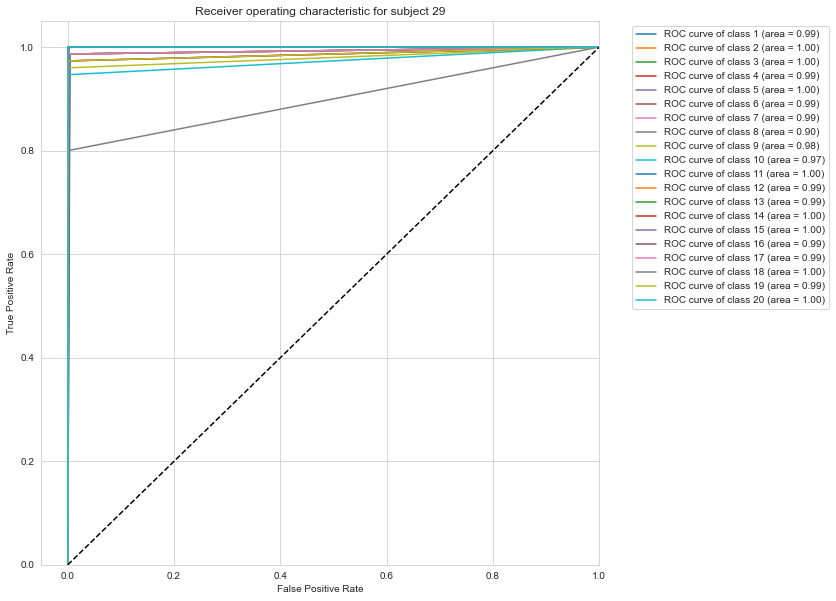

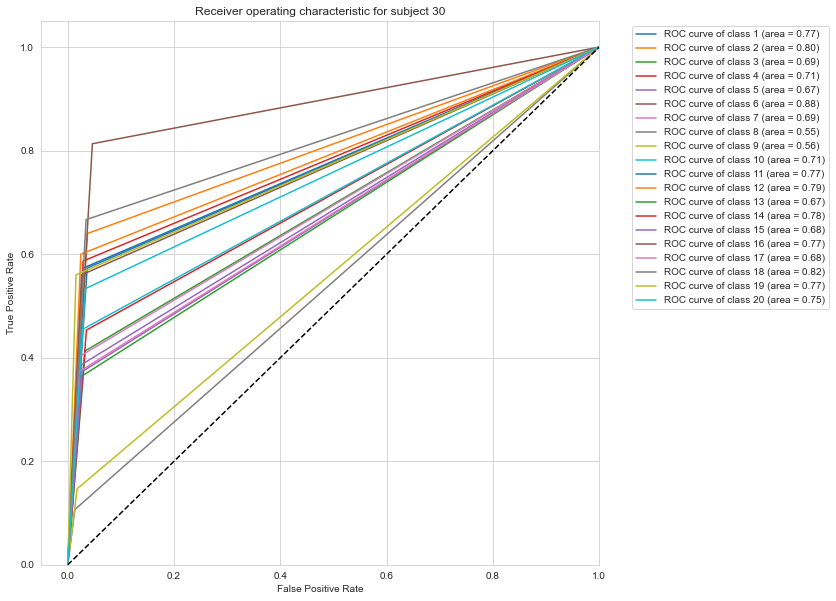

In [77]:
model = 'cca'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
results = {}

if(dataset == '8_channel_cVEP'):
    n_subjects = 30
    if(model=='cca'):
        n_classes = 20
    else:
        n_classes = 21
else:
    n_subjects = 5
    n_classes = 35

with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_all = pickle.load(handle)

results_fixed = fix_roc(results_all,n_subjects)
results_cca = group_results(results_fixed,n_subjects)

plot_roc_curve(results_cca,n_subjects,n_classes, model, dataset)

In [ ]:
n_subjecs = 30
n_folds = 15

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'within_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

plt.figure(figsize=(7,7))
cm = results_multi_objective_cnn[1][2]['category_cm']
labels = np.arange(1,22)
cm_plot = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
cm_plot.set(xlabel='Predicted labels', ylabel='True labels')
plt.show()

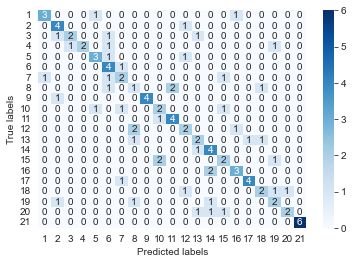

In [58]:
n_subjecs = 30
n_folds = 15

model = 'multi_objective_cnn'
dataset = '8_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
    results_multi_objective_cnn = pickle.load(handle)

cm = results_multi_objective_cnn[2][2]['category_cm']    
labels = np.arange(1,22)
cm_plot = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
cm_plot.set(xlabel='Predicted labels', ylabel='True labels')
plt.show()

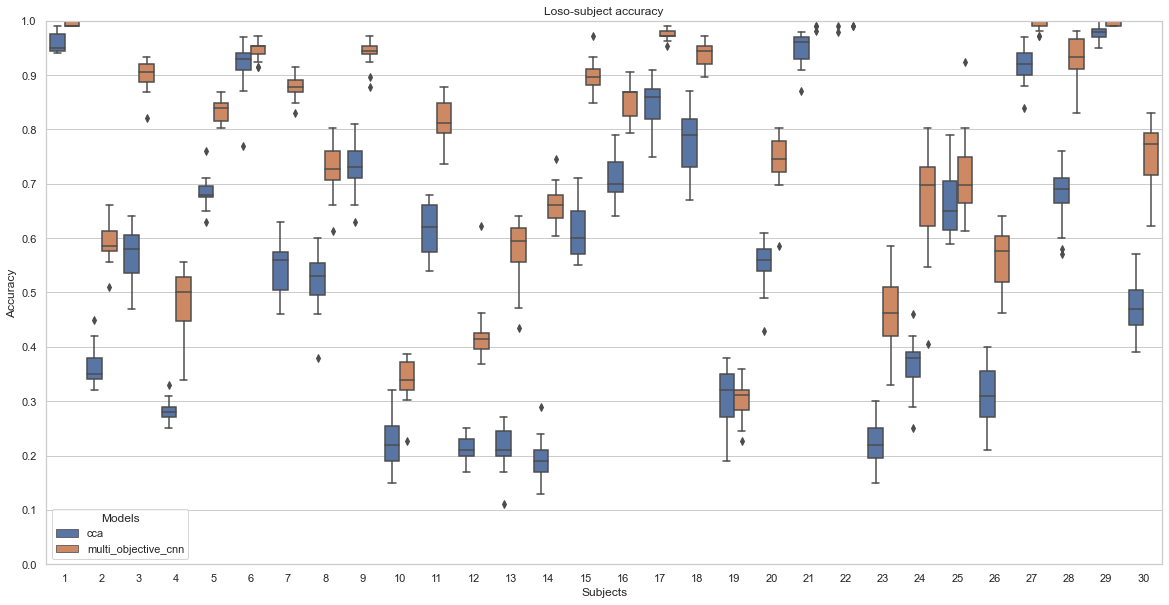

In [86]:
models = ['cca','multi_objective_cnn']
datasets = ['8_channel_cVEP','256_channel_cVEP']
mode = 'loso_subject'
results = {}
for dataset in datasets:
    for model in models:
        if(dataset == '8_channel_cVEP'):
            n_subjects = 30
            if(model=='cca'):
                n_classes = 20
            else:
                n_classes = 21
        else:
            n_subjects = 5
            n_classes = 35
            
        with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
            results_all = pickle.load(handle)
        
        #results_fixed = fix_roc(results_all,n_subjects)
        results[model] = group_results(results_all,n_subjects)
    
        
    group = results['cca']['group']
    group1 = results['cca']['category_accuracy']
    group2 = results['multi_objective_cnn']['category_accuracy']
    plot_box_plot('cca','multi_objective_cnn', group, group1,group2,'Loso-subject')
        
    break
#plot_roc_curve(results_cca,n_subjects,n_classes, model, dataset)

In [186]:
model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
        results = pickle.load(handle)
        results_multi_objective_cnn = group_results(results) 

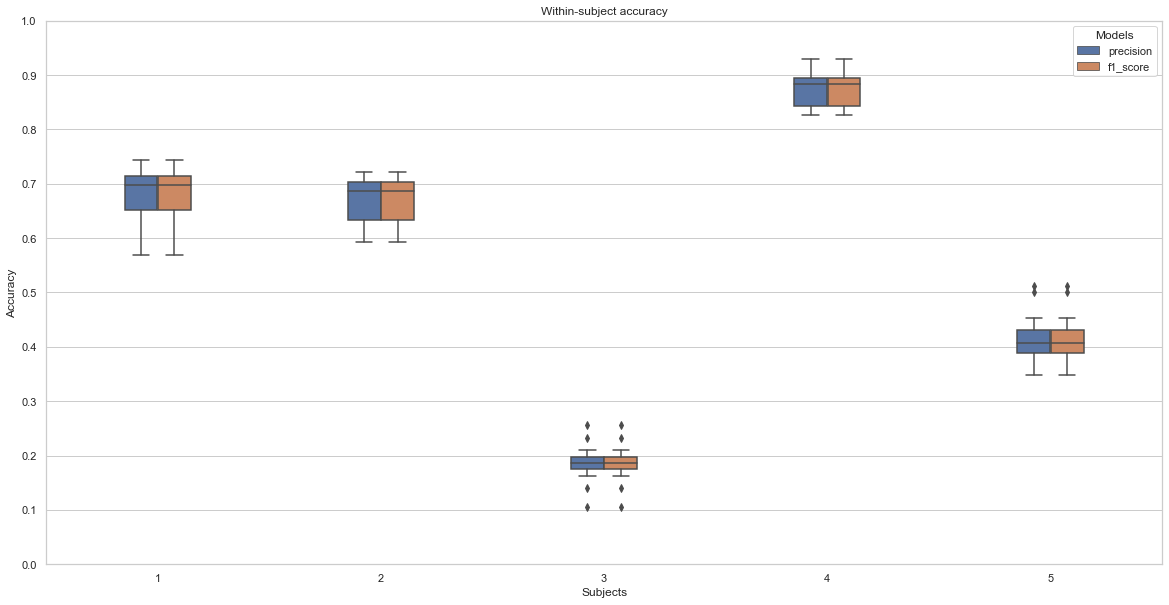

In [170]:
group = results_multi_objective_cnn['group']
group1_label = 'precision'
group2_label = 'f1_score'
group1 = results_multi_objective_cnn[group1_label]
group2 = results_multi_objective_cnn[group2_label]


df = pd.DataFrame({'Subjects':group,group1_label:group1,group2_label:group2})
df = df[['Subjects',group1_label,group2_label]]

sns.set(rc={'figure.figsize':(20,10)})
sns.set_style("whitegrid")
dd=pd.melt(df,id_vars=['Subjects'],value_vars=[group1_label,group2_label],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models', width=0.3)
ax.set_title('Within-subject accuracy')
ax.set(ylabel='Accuracy')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0,1.01,0.1))
plt.show()

In [167]:
def group_results(results):
    group = []
    category_accuracy = []
    sequence_accuracy = []
    ITR = []
    recall_all = []
    precision_all = []
    f1_score_all = []
    results_grouped = {}
    for i in results.keys():
        results_cv = results[i] 
        if 'history' in results_cv.keys():
            results_cv_len= len(results_cv)-1
        else:
            results_cv_len= len(results_cv)
            
        for j in range(1,results_cv_len+1):
            group.append(i)
            category_accuracy.append(float(results_cv[j]['category_accuracy']))
            ITR.append(float(results_cv[j]['ITR']))

            if(model == 'multi_objective_cnn'):
                sequence_accuracy.append(float(results_cv[j]['sequence_accuracy']))
                cm = results[i][j]['category_cm']
                recall = float(results[i][j]['recall'])
                precision = float(results[i][j]['precision'])
                f1_score = float(results[i][j]['f1_score'])
                recall_all.append(recall)
                precision_all.append(precision)
                f1_score_all.append(f1_score)
                
    results_grouped['group'] = group            
    results_grouped['category_accuracy'] = category_accuracy
    results_grouped['sequence_accuracy'] = sequence_accuracy
    results_grouped['ITR'] = ITR
    if(model == 'multi_objective_cnn'):
        results_grouped['recall'] = recall_all
        results_grouped['precision'] = precision_all
        results_grouped['f1_score'] = f1_score_all

    return results_grouped

In [136]:
model = 'cca'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
        results = pickle.load(handle)
        results_cca = group_results(results)  
        
model = 'multi_objective_cnn'
dataset = '256_channel_cVEP'
mode = 'loso_subject'
with open('./results/{}/{}/{}/{}_{}.pickle'.format(model,dataset,mode,model,mode), 'rb') as handle:
        results = pickle.load(handle)
        results_multi_objective_cnn = group_results(results)   

1 1 0.6990740740740741 0.7574074074074075
1 2 0.6064814814814814 nan
1 3 0.6990740740740741 nan
1 4 0.6018518518518517 nan
1 5 0.6527777777777778 nan
1 6 0.7268518518518517 0.775462962962963
1 7 0.7546296296296295 0.7875
1 8 0.7083333333333334 nan
1 9 0.6898148148148148 nan
1 10 0.6990740740740741 0.725
1 11 0.7037037037037037 nan
1 12 0.6481481481481481 nan
1 13 0.6342592592592593 0.7060185185185185
1 14 0.6805555555555556 nan
1 15 0.6527777777777778 nan
2 1 0.7268518518518517 nan
2 2 0.7685185185185186 nan
2 3 0.7175925925925926 nan
2 4 0.7407407407407408 nan
2 5 0.8055555555555556 nan
2 6 0.75 nan
2 7 0.699074074074074 nan
2 8 0.7638888888888888 nan
2 9 0.7037037037037037 nan
2 10 0.7499999999999999 0.8027777777777777
2 11 0.7731481481481481 0.8125
2 12 0.6990740740740741 0.7597222222222222
2 13 0.699074074074074 nan
2 14 0.75 nan
2 15 0.736111111111111 nan
3 1 0.20370370370370366 nan
3 2 0.11574074074074073 nan
3 3 0.07407407407407407 nan
3 4 0.16203703703703703 nan
3 5 0.166666666

C:\Users\rohit\AppData\Local\Temp\ipykernel_15520\2183819351.py:26: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diag(cm) / np.sum(cm, axis = 0)


In [114]:
results_multi_objective_cnn['precision'][0][0][0]

[[...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...]]

In [100]:
len(results_multi_objective_cnn['category_accuracy'])

70

In [ ]:
df = pd.DataFrame({'Subjects':group,'sequence_accuracy':sequence_accuracy,'category_accuracy':category_accuracy})
df = df[['Subjects','sequence_accuracy','category_accuracy']]

sns.set(rc={'figure.figsize':(20,10)})
sns.set_style("whitegrid")
dd=pd.melt(df,id_vars=['Subjects'],value_vars=['sequence_accuracy','category_accuracy'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models', width=0.3)
ax.set_title('Within-subject accuracy')
ax.set(ylabel='Accuracy')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0,1.01,0.1))
plt.show()

In [21]:
results[1][1].keys()

dict_keys(['category_accuracy', 'sequence_accuracy', 'sequence_cm', 'category_cm', 'ITR'])

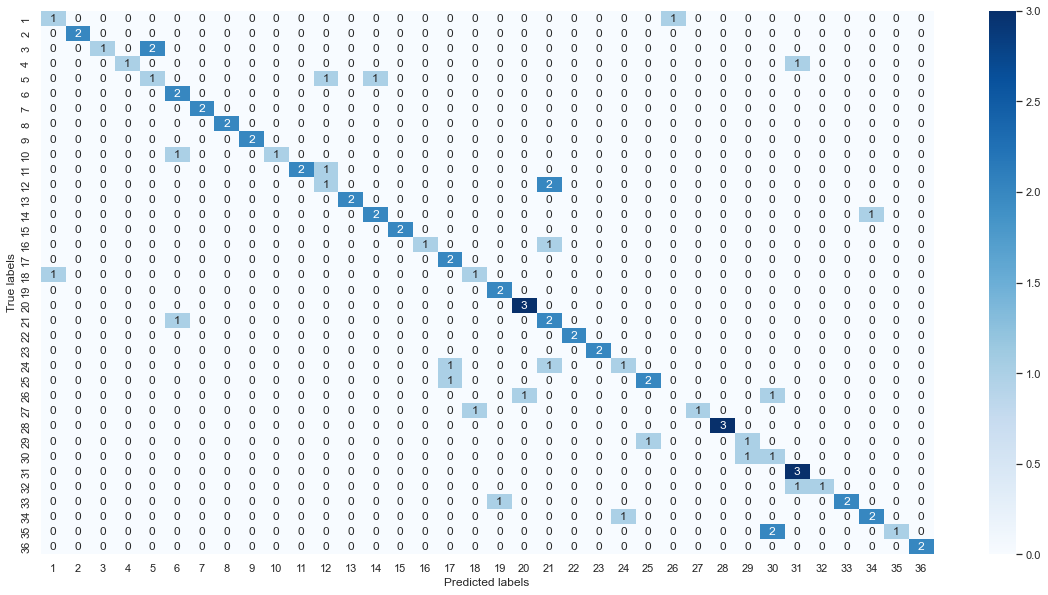

In [66]:
labels = np.arange(1,37)
cm_plot = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
cm_plot.set(xlabel='Predicted labels', ylabel='True labels')
plt.show()

In [55]:
cm = results[1][1]['category_cm']
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

recall = np.mean(recall)
precision = np.mean(precision)

f1_score = 2*((precision*recall)/(precision+recall))
recall,precision,f1_score 

(0.6990740740740741, 0.7574074074074075, 0.7270725907089544)

In [125]:
group = []
category_accuracy = []
sequence_accuracy = []
ITR = []
for i in results.keys():
    results_cv = results[i] 
    for j in range(1,len(results_cv)-1):
        group.append(i)
        category_accuracy.append(float(results_cv[j]['category_accuracy']/100))
        sequence_accuracy.append(float(results_cv[j]['sequence_accuracy']/100))
        ITR.append(float(results_cv[j]['ITR']))
        
        cm = results[i][j]['category_cm']
        recall = np.diag(cm) / np.sum(cm, axis = 1)
        precision = np.diag(cm) / np.sum(cm, axis = 0)

        recall = np.mean(recall)
        precision = np.mean(precision)
        f1_score = 2*((precision*recall)/(precision+recall))

C:\Users\rohit\AppData\Local\Temp\ipykernel_15520\2638329703.py:15: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diag(cm) / np.sum(cm, axis = 0)


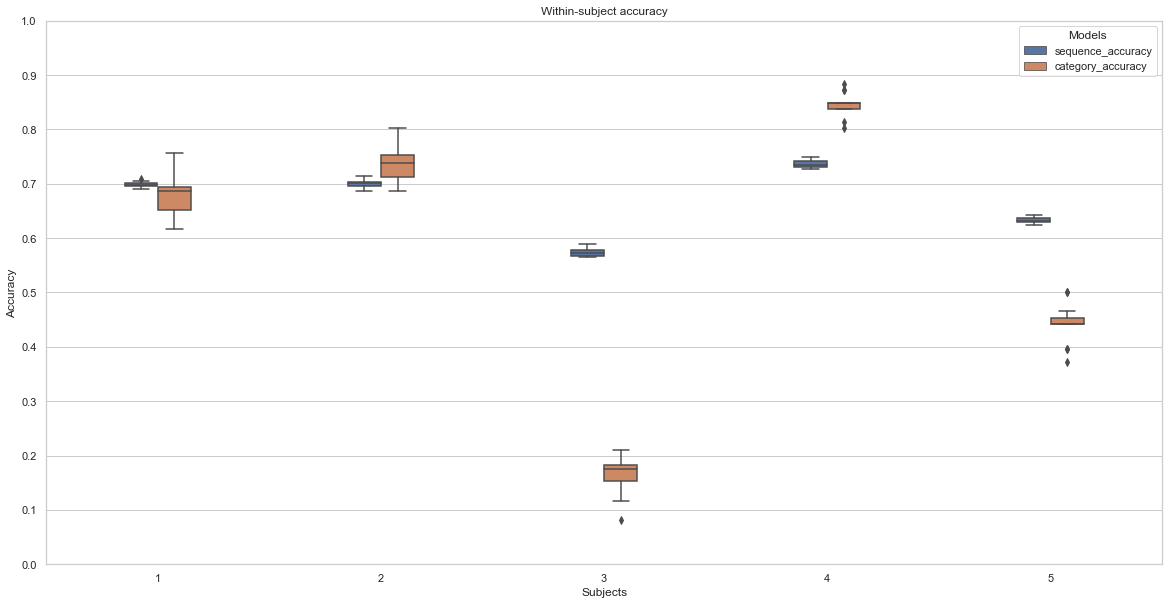

In [53]:
df = pd.DataFrame({'Subjects':group,'sequence_accuracy':sequence_accuracy,'category_accuracy':category_accuracy})
df = df[['Subjects','sequence_accuracy','category_accuracy']]

sns.set(rc={'figure.figsize':(20,10)})
sns.set_style("whitegrid")
dd=pd.melt(df,id_vars=['Subjects'],value_vars=['sequence_accuracy','category_accuracy'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models', width=0.3)
ax.set_title('Within-subject accuracy')
ax.set(ylabel='Accuracy')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0,1.01,0.1))
plt.show()

In [ ]:
group = []
category_accuracy = []
sequence_accuracy = []
ITR = []
for i in results_cnn_ts.keys():
    results_cv = results[i]
    
    for j in range(1,len(results_cv)-1):
        group.append(i)
        category_accuracy.append(float(results_cv[j]['category_accuracy']))
        sequence_accuracy.append(float(results_cv[j]['sequence_accuracy']))
        ITR.append(float(results_cv[j]['ITR']))

df = pd.DataFrame({'Subjects':group,'cnn_ts':cnn_ts_list,'cnn':cnn_list})
df = df[['Subjects','cnn_ts','cnn']]

sns.set(rc={'figure.figsize':(20,10)})
dd=pd.melt(df,id_vars=['Subjects'],value_vars=['cnn_ts','cnn'],var_name='Models')
ax = sns.boxplot(x='Subjects',y='value',data=dd,hue='Models')
ax.set_title('Within-subject accuracy')
ax.set(ylabel='Accuracy')
plt.show()

In [8]:
results[1][1].keys()

dict_keys(['category_accuracy', 'sequence_accuracy', 'ITR'])